In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import seaborn as sns
import glob
from scipy.spatial import ConvexHull
from scipy.optimize import linear_sum_assignment
from scipy.stats import multivariate_normal
from scipy.spatial import Delaunay
from sklearn.cluster import KMeans
import warnings
import json
import networkx as nx
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
from utils import *

## Get Tracks 
### iterate over all files

In [4]:
import json

path_to_tracks = "./xy_data/"

def get_tracks(dir: str):
    tracks = {}
    for file in glob.glob(dir + "*.txt"):
        track = pd.read_csv(file, sep=",", header=None)
        track.columns = ["frame_number", "track_id", "role", "xbox", "ybox", "w", "h", "xworld", "yworld", "IoU"]

        filename = file.split("/")[-1]
        tracks[filename] = track
    return tracks

tracks = get_tracks(path_to_tracks)


### print the unique roles per file

In [5]:
unique_roles = {filename: track['role'].unique() for filename, track in tracks.items()}
print(unique_roles)

{'fis2_data.txt': array([  3,  -1,   2,   0,   1,   4, 166, 155]), 'gr2_data.txt': array([0, 1, 2, 3, 4]), 't1_data.txt': array([ 0,  1,  3,  2, -1,  4]), 'fried1_data.txt': array([ 0,  1, -1,  2,  3,  4]), 'st2_data.txt': array([ 1,  0,  3, -1,  2,  4]), 'w2_data.txt': array([0, 1, 2]), 'stv2_data.txt': array([  1,   4,  -1,   0,   3,   2, 400, 396]), 'm1_data.txt': array([ 1,  0,  2,  3, -1,  4]), 'friedr2_data.txt': array([ 1, -1,  0,  2,  3,  4]), 't2_data.txt': array([ 3,  1, -1,  2,  0,  4]), 'alt_data.txt': array([ 0,  1,  3, -1,  2,  4]), 'alt2_data.txt': array([ 0,  2,  1,  3, -1,  4]), 'fis1_data.txt': array([ 1,  0,  2, -1,  3,  4]), 'gr1_data.txt': array([0, 2, 1, 3, 4]), 'm2_data.txt': array([ 1,  0,  3, -1,  2,  4]), 'stv1_data.txt': array([1, 0, 3, 2, 4]), 'w1_data.txt': array([ 1,  0,  2, -1]), 'st1_data.txt': array([ 1,  2,  0, -1,  4,  3])}


In [6]:
filtered_tracks = {filename: track[(track['role'] == 0) | (track['role'] == 1)] for filename, track in tracks.items()}


In [7]:
filtered_tracks_df = pd.concat([track.assign(filename=filename) for filename, track in filtered_tracks.items()])

### print the value counts of all files from role 0 and 1

In [8]:
filtered_tracks_df["role"].value_counts()

role
1    221990
0    221469
Name: count, dtype: int64

### print the unique filenames

In [9]:
unique_filenames = filtered_tracks_df["filename"].unique()
print(unique_filenames)

['fis2_data.txt' 'gr2_data.txt' 't1_data.txt' 'fried1_data.txt'
 'st2_data.txt' 'w2_data.txt' 'stv2_data.txt' 'm1_data.txt'
 'friedr2_data.txt' 't2_data.txt' 'alt_data.txt' 'alt2_data.txt'
 'fis1_data.txt' 'gr1_data.txt' 'm2_data.txt' 'stv1_data.txt'
 'w1_data.txt' 'st1_data.txt']


### role count per player grouped in filename

In [10]:
role_counts_per_track = {
    filename: track[track['role'].isin([0, 1])].groupby('track_id')['role'].value_counts().unstack(fill_value=0)
    for filename, track in filtered_tracks.items()
}

role_counts_list = []
for filename, counts in role_counts_per_track.items():
    counts['filename'] = filename
    role_counts_list.append(counts)

role_counts_df = pd.concat(role_counts_list)
role_counts_df

role         0     1       filename
track_id                           
147       1246     0  fis2_data.txt
149          0  1250  fis2_data.txt
150       1237     0  fis2_data.txt
151       1225     0  fis2_data.txt
152       1250     0  fis2_data.txt
...        ...   ...            ...
667          0  1250   st1_data.txt
668       1249     0   st1_data.txt
669          0  1249   st1_data.txt
672       1248     0   st1_data.txt
673       1250     0   st1_data.txt

[362 rows x 3 columns]

### print unique track_ids per role (0 and 1)

In [11]:
track_ids = filtered_tracks_df['track_id'].unique()

tracks_0 = filtered_tracks_df[filtered_tracks_df["role"] == 0]
tracks_0["track_id"].unique()   

tracks_1 = filtered_tracks_df[filtered_tracks_df["role"] == 1]
tracks_1["track_id"].unique()


array([149, 154, 155, 160, 161, 163, 164, 165, 166, 168, 258, 263, 265,
       266, 268, 269, 273, 274, 275, 279, 629, 630, 635, 636, 637, 641,
       642, 645, 647, 648, 171, 176, 177, 186, 187, 188, 192, 193, 194,
       197, 676, 681, 684, 686, 689, 690, 691, 692, 693, 694, 505, 506,
       509, 513, 514, 516, 523, 524, 526, 527, 528, 381, 384, 385, 387,
       391, 392, 394, 396, 400, 402, 280, 283, 286, 287, 293, 296, 297,
       301, 302, 303, 201, 204, 206, 207, 211, 216, 218, 222, 223, 224,
       608, 610, 611, 614, 615, 616, 619, 621, 622, 626,  62,  65,  70,
        71,  72,  73,  77,  78,  79,  82,  93,  94,  95,  98, 103, 107,
       109, 113, 114, 116, 118, 120, 123, 125, 129, 132, 137, 138, 139,
       140, 240, 241, 245, 244, 243, 247, 248, 250, 252, 254, 307, 313,
       317, 319, 321, 322, 323, 327, 328, 331, 357, 362, 365, 366, 367,
       372, 374, 376, 378, 456, 458, 459, 463, 466, 470, 472, 473, 476,
       479, 478, 651, 653, 654, 655, 656, 659, 664, 666, 667, 66

### print the total number of role counts of each unique player track_id

In [12]:
x = filtered_tracks_df.groupby("filename")[["track_id", "role"]].apply(lambda x: x.drop_duplicates())
x_df = x.reset_index()
x_df.groupby("filename")["role"].value_counts().unstack(fill_value=0)

role               0   1
filename                
alt2_data.txt     10  10
alt_data.txt      10  10
fis1_data.txt     10  10
fis2_data.txt     10  10
fried1_data.txt    9  10
friedr2_data.txt  10  10
gr1_data.txt      10  10
gr2_data.txt      10  10
m1_data.txt       10  10
m2_data.txt       10  10
st1_data.txt      10  10
st2_data.txt      10  10
stv1_data.txt     10   9
stv2_data.txt     10  10
t1_data.txt       10  10
t2_data.txt       10  10
w1_data.txt       11  11
w2_data.txt       11  11

we see that not every clip has 10 players detected - some has only 9, some have 11, which dont work for for real applications, when it comes to predict team formations 

In [13]:
role = 1
excluded_files = ['./xy_data/stv1_data.txt', './xy_data/w1_data.txt', './xy_data/w2_data.txt']

### exclude the files which have not 10 unique players in the clip

In [14]:
excluded_files_1 = ['./xy_data/stv1_data.txt', './xy_data/w1_data.txt', './xy_data/w2_data.txt']
excluded_files_0 = ['./xy_data/fried1_data.txt', './xy_data/w1_data.txt', './xy_data/w2_data.txt']

In [15]:
#TODO: need to adapt excluded_files_0 and excluded_files_1 to the new dataset

def create_role_pdfs_of_tracks(path:str, role:int):
    if role == 0:
        excluded_files = excluded_files_0
    else:
        excluded_files = excluded_files_1
    
    tracks = {}
    for file in glob.glob(path + "*.txt"):
        if file in excluded_files:
            print(f'Skipping file {file}')
            continue # Skip files that are in the excluded_files list
        track = pd.read_csv(file, sep=",", header=None)
        track.columns = ["frame_number", "track_id", "role", "xbox", "ybox", "w", "h", "xworld", "yworld", "IoU"]
        track = track[(track['role'] == role)]
 
        players_role = normalize_tracking_data(track)
        n_roles = np.unique(players_role['track_id'])
        print(f"Number of roles: {len(n_roles)}")
        players_role, initial_means = initialize_roles_with_kmeans(players_role, n_roles)

        # Iteratively assign roles and refine PDFs
        players_role, role_pdfs = update_roles(players_role, initial_means, separation_bias=20.0)
        tracks.update({file: role_pdfs})
    return tracks

In [16]:
tracks_role_1 = create_role_pdfs_of_tracks(path=path_to_tracks, role=1)
tracks_role_0 = create_role_pdfs_of_tracks(path=path_to_tracks, role=0)

Number of roles: 10
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Number of roles: 10
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Number of roles: 10
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Number of roles: 10
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Number of roles: 10
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Skipping file ./xy_data/w2_data.txt
Number of roles: 10
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Number of roles: 10
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iterati

In [17]:
def plot_tracks(tracks):
    for filename, roles in tracks.items():
        plt.figure(figsize=(10, 8))
        plt.title(f"Tracks for {filename}")
        for role_id, pdf in roles.items():
            mean = pdf.mean
            cov = pdf.cov
            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
            width, height = 2 * np.sqrt(eigenvalues)
            ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='r', fc='None', lw=2)
            plt.gca().add_patch(ell)
            plt.scatter(mean[0], mean[1], s=100, label=f'Role {role_id}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.show()



In [19]:
import json
from scipy.stats import multivariate_normal

def serialize_multivariate_normal(mvn):
    return {
        'mean': mvn.mean.tolist(),
        'covariance': mvn.cov.tolist()
    }

tracks_role_1_serializable = {
    filename: {str(role_id): serialize_multivariate_normal(pdf) for role_id, pdf in roles.items()}
    for filename, roles in tracks_role_1.items()
}

tracks_role_0_serializable = {
    filename: {str(role_id): serialize_multivariate_normal(pdf) for role_id, pdf in roles.items()}
    for filename, roles in tracks_role_0.items()
}


with open('tracks_role_1.json', 'w') as f:
    json.dump(tracks_role_1_serializable, f)

with open('tracks_role_0.json', 'w') as f:
    json.dump(tracks_role_0_serializable, f)

In [20]:
import json
import numpy as np

# Load your JSON data
with open('tracks_role_1.json', 'r') as f:
    data_1 = json.load(f)

formations_1 = []  # List to store each team's formation as a list of players.
team_names_1 = []  # To keep track of team IDs

for team, players in data_1.items():
    formation = []
    for player, stats in players.items():
        mean = np.array(stats['mean'])           # e.g., [x, y]
        covariance = np.array(stats['covariance']) # e.g., 2x2 matrix
        formation.append((mean, covariance))
    formations_1.append(formation)
    team_names_1.append(team)


In [26]:
import json
import numpy as np

# Load your JSON data
with open('tracks_role_0.json', 'r') as f:
    data_0 = json.load(f)

formations_0 = []  # List to store each team's formation as a list of players.
team_names_0 = []  # To keep track of team IDs

for team, players in data_0.items():
    formation = []
    for player, stats in players.items():
        mean = np.array(stats['mean'])           # e.g., [x, y]
        covariance = np.array(stats['covariance']) # e.g., 2x2 matrix
        formation.append((mean, covariance))
    formations_0.append(formation)
    team_names_0.append(team)


In [21]:
from scipy.linalg import sqrtm

def wasserstein_distance_gaussian(mean1, cov1, mean2, cov2):
    # Compute the squared difference between the means.
    mean_diff_sq = np.linalg.norm(mean1 - mean2)**2

    # Compute the matrix square root of cov1
    cov1_sqrt = sqrtm(cov1)
    
    # Compute the product cov1_sqrt * cov2 * cov1_sqrt
    product = cov1_sqrt @ cov2 @ cov1_sqrt
    
    # Compute the square root of the product matrix
    sqrt_product = sqrtm(product)
    
    # Compute the trace term
    trace_term = np.trace(cov1 + cov2 - 2 * sqrt_product)
    
    # Return the 2-Wasserstein distance (ensure non-negative)
    return np.sqrt(max(mean_diff_sq + trace_term, 0))


In [22]:
from scipy.optimize import linear_sum_assignment

def compute_emd(formation1, formation2):
    # formation1 and formation2 are lists of 10 players: (mean, covariance)
    n = len(formation1)
    m = len(formation2)
    cost_matrix = np.zeros((n, m))
    
    for i in range(n):
        for j in range(m):
            mean1, cov1 = formation1[i]
            mean2, cov2 = formation2[j]
            cost_matrix[i, j] = wasserstein_distance_gaussian(mean1, cov1, mean2, cov2)
    
    # Solve the assignment problem (Hungarian algorithm)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_cost = cost_matrix[row_ind, col_ind].sum()
    
    # Since each player has equal weight (1/10), the EMD is the total_cost divided by the total mass (which is 1)
    return total_cost


### distances matrix for 1

In [ ]:
num_formations_1 = len(formations_1)
print(f"Number of formations for role: {num_formations_1}")
distance_matrix_1 = np.zeros((num_formations_1, num_formations_1))

for i in range(num_formations_1):
    for j in range(i + 1, num_formations_1):
        distance_1 = compute_emd(formations_1[i], formations_1[j])
        distance_matrix_1[i, j] = distance_1
        distance_matrix_1[j, i] = distance_1  # because the distance is symmetric


Number of formations for role: 15


### distance matrix for role 0

In [27]:
num_formations_0 = len(formations_0)
print(f"Number of formations role 0: {num_formations_0}")
distance_matrix_0 = np.zeros((num_formations_0, num_formations_0))

for i in range(num_formations_0):
    for j in range(i + 1, num_formations_0):
        distance_0 = compute_emd(formations_0[i], formations_0[j])
        distance_matrix_0[i, j] = distance_0
        distance_matrix_0[j, i] = distance_0  # because the distance is symmetric


Number of formations role 0: 15


## Plot formations of role 0

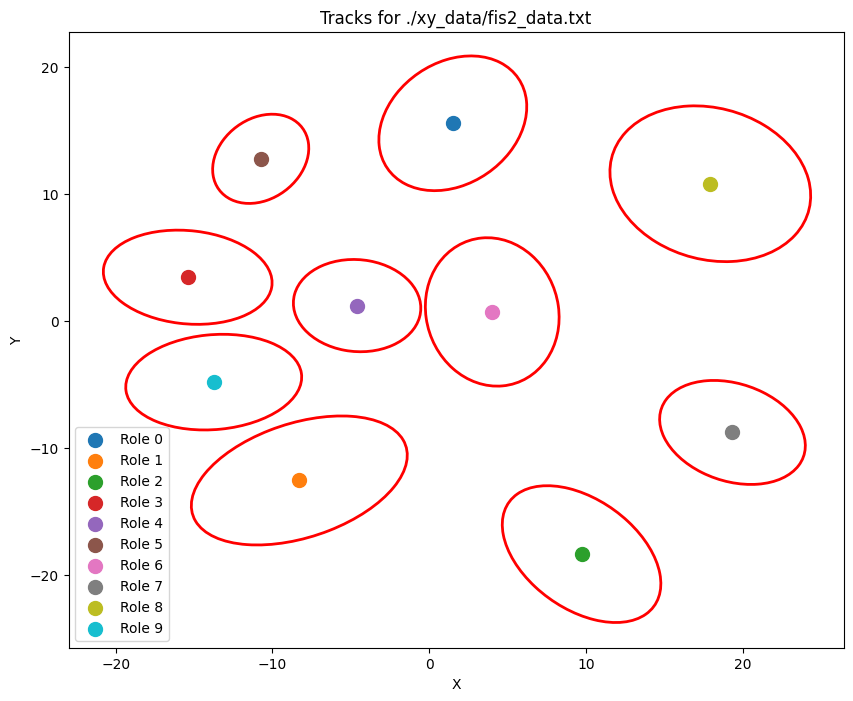

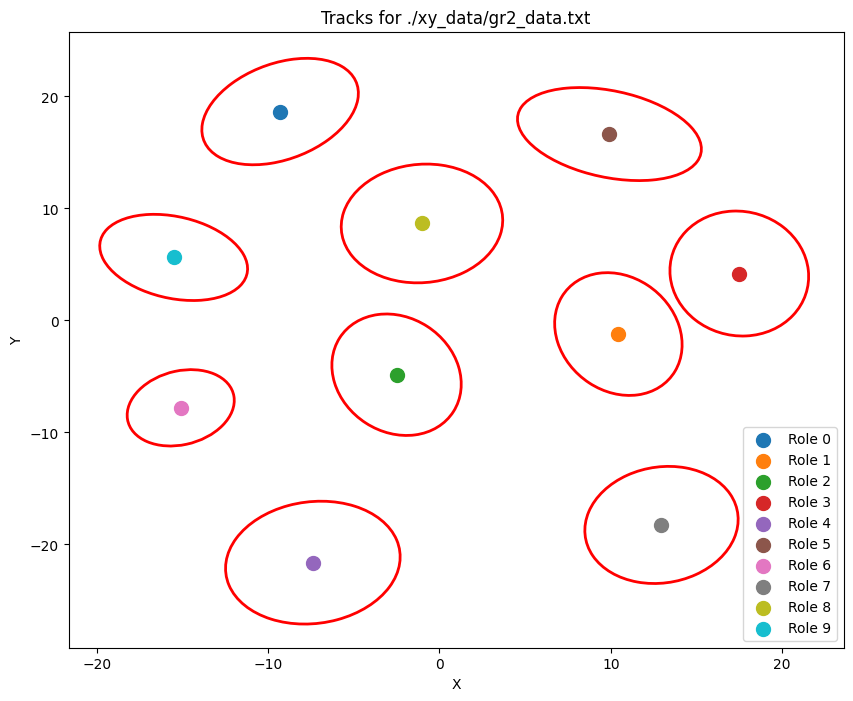

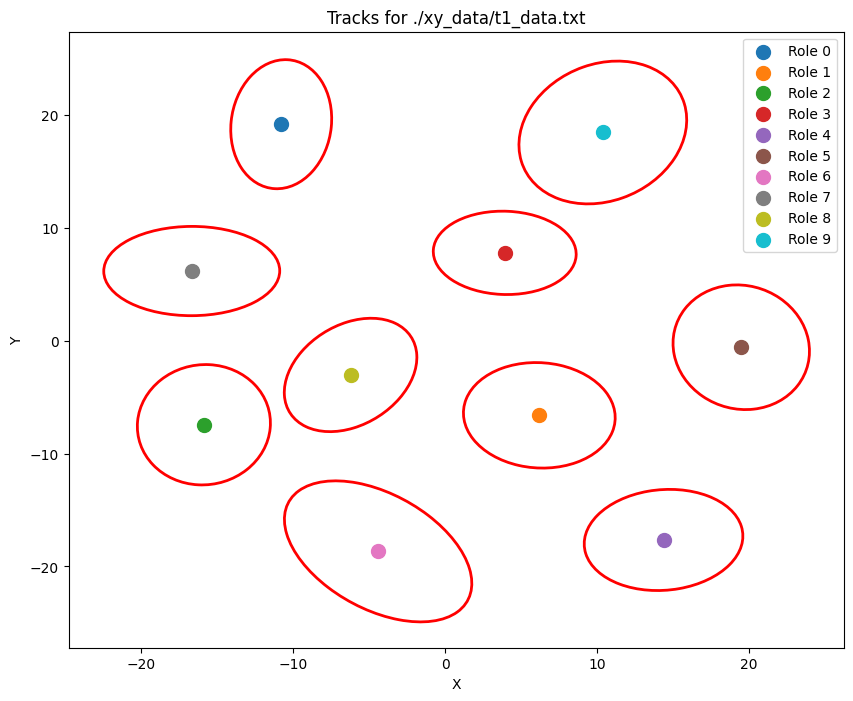

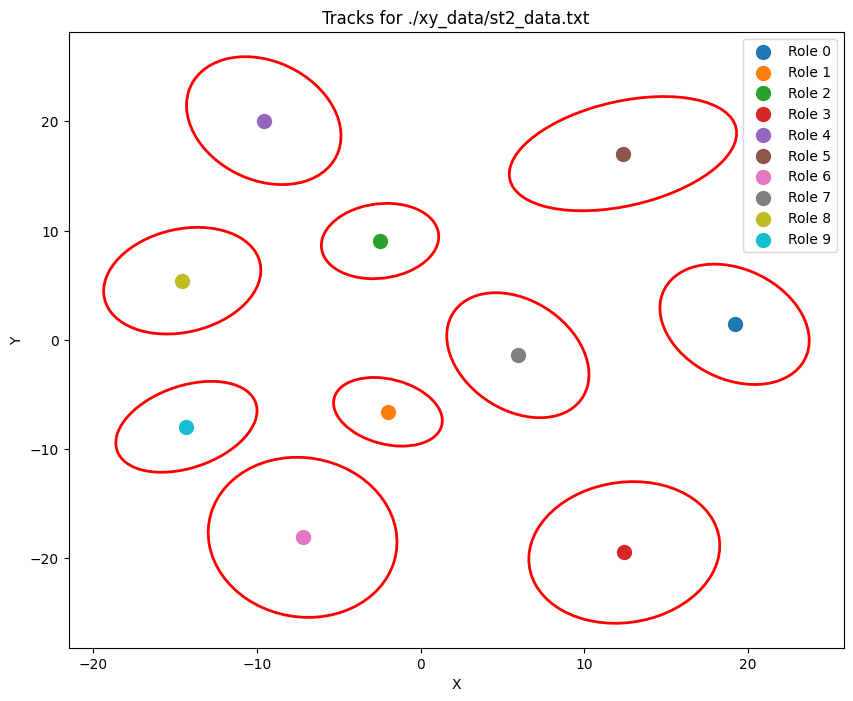

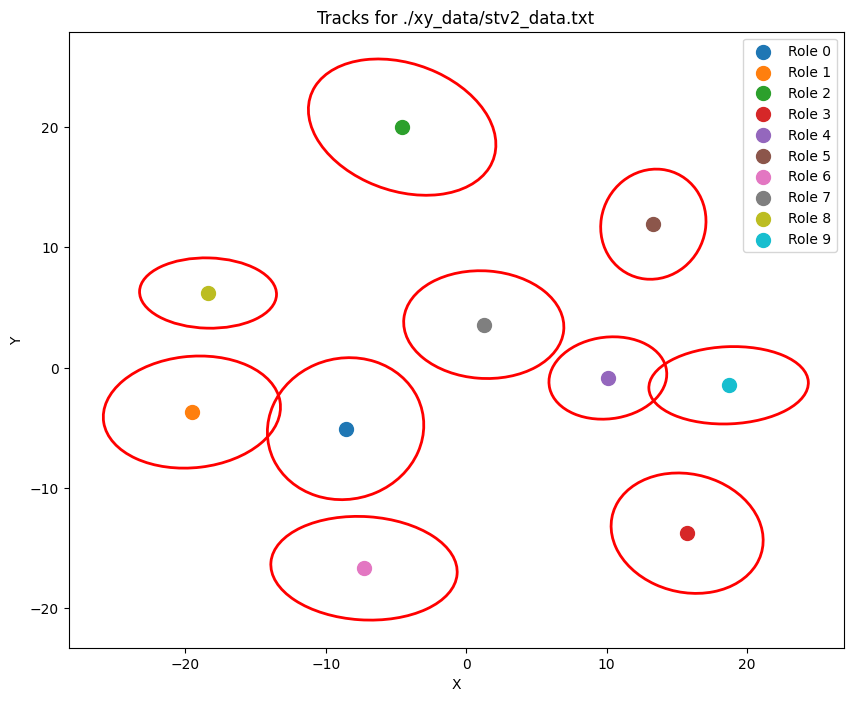

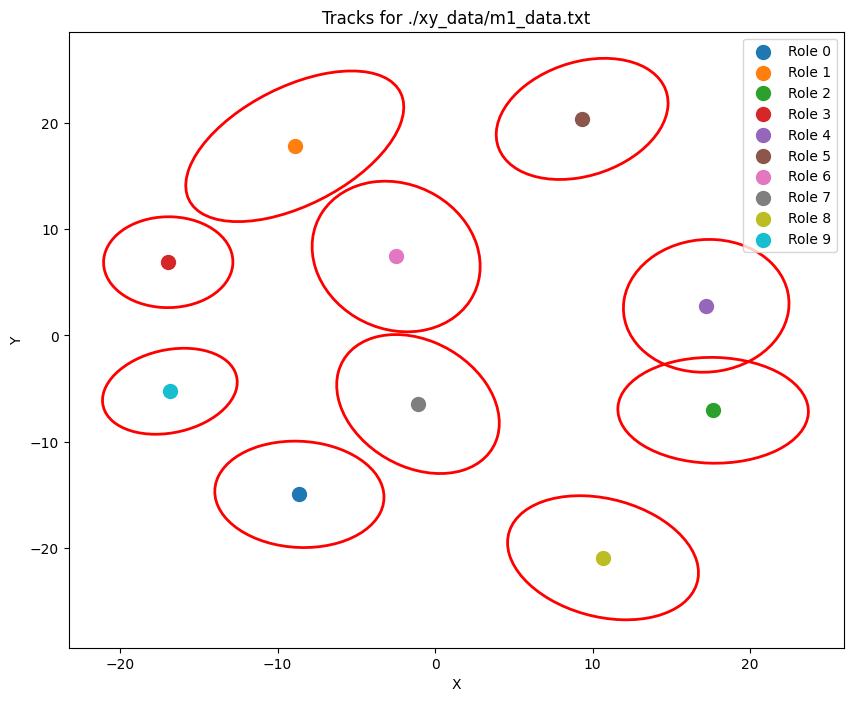

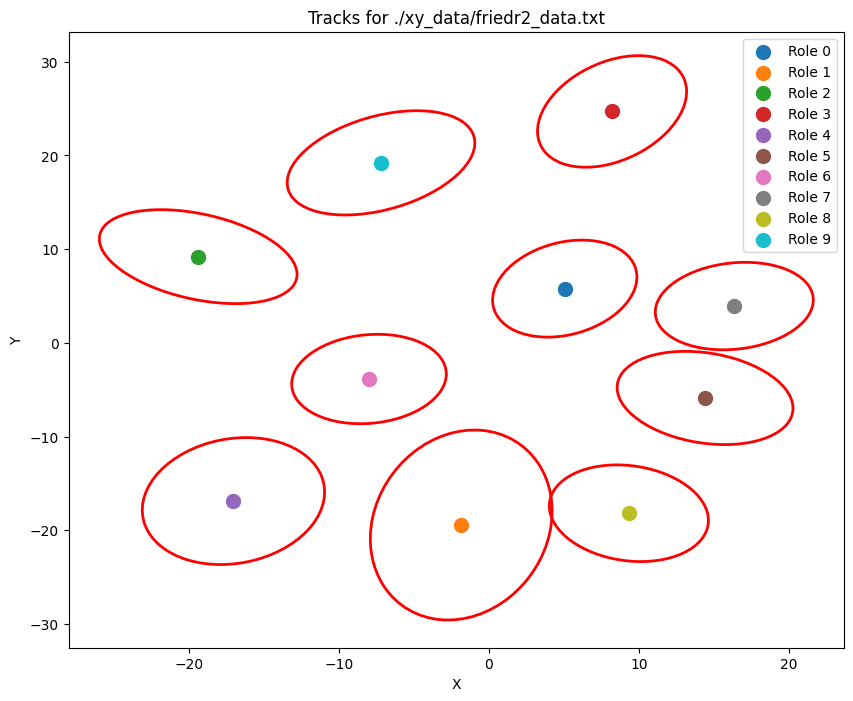

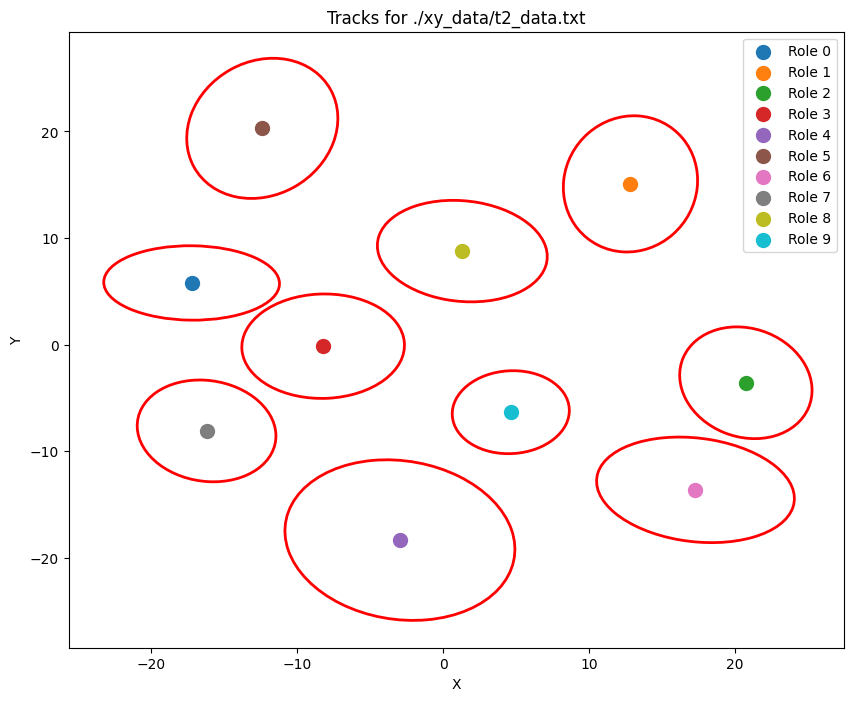

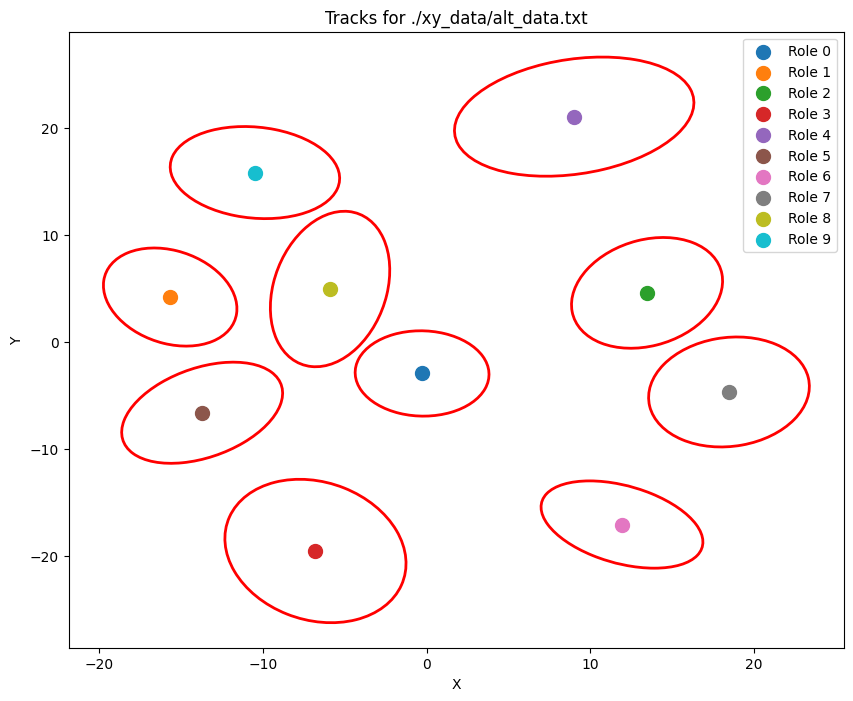

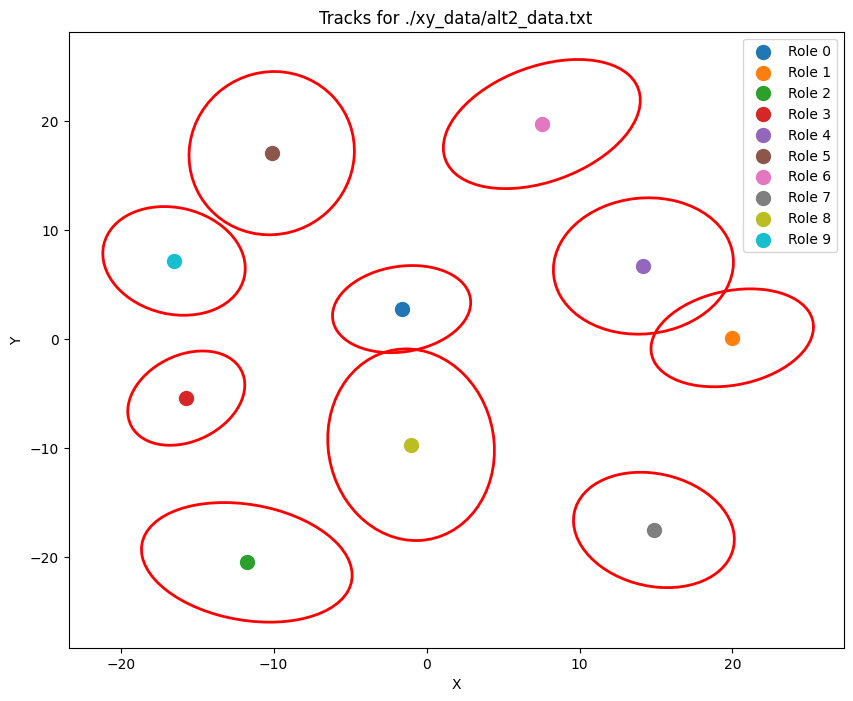

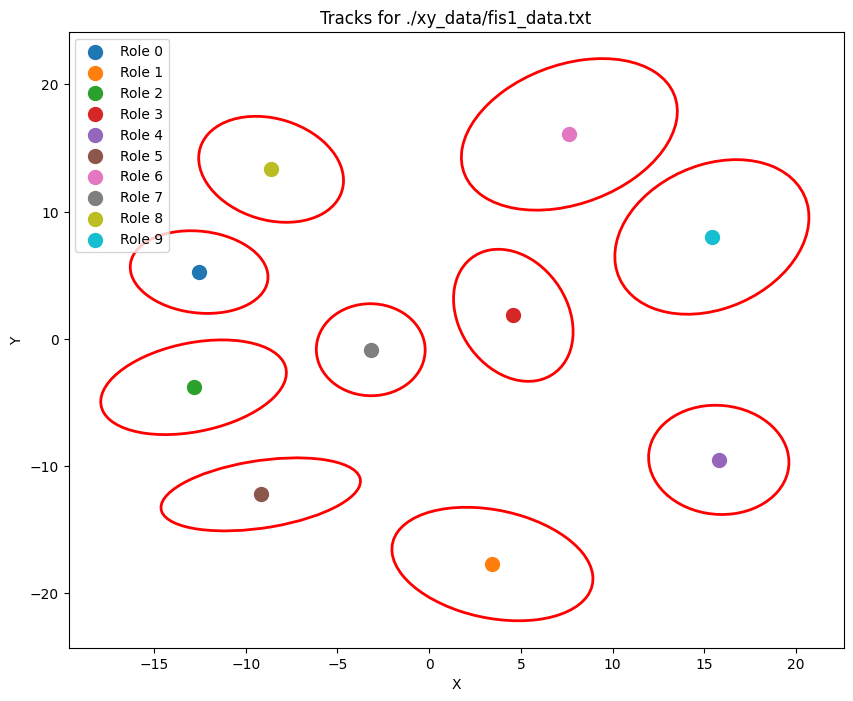

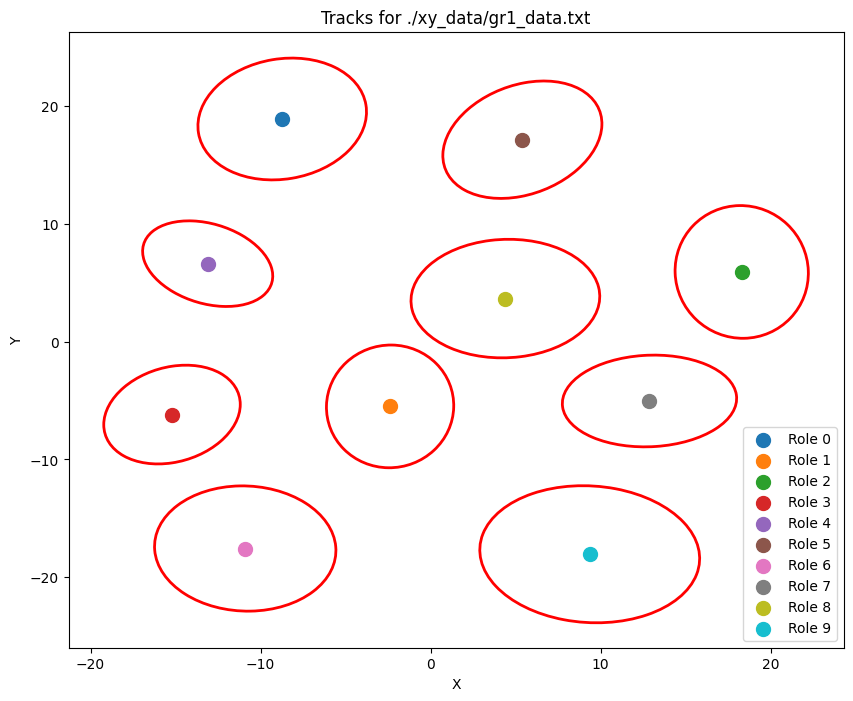

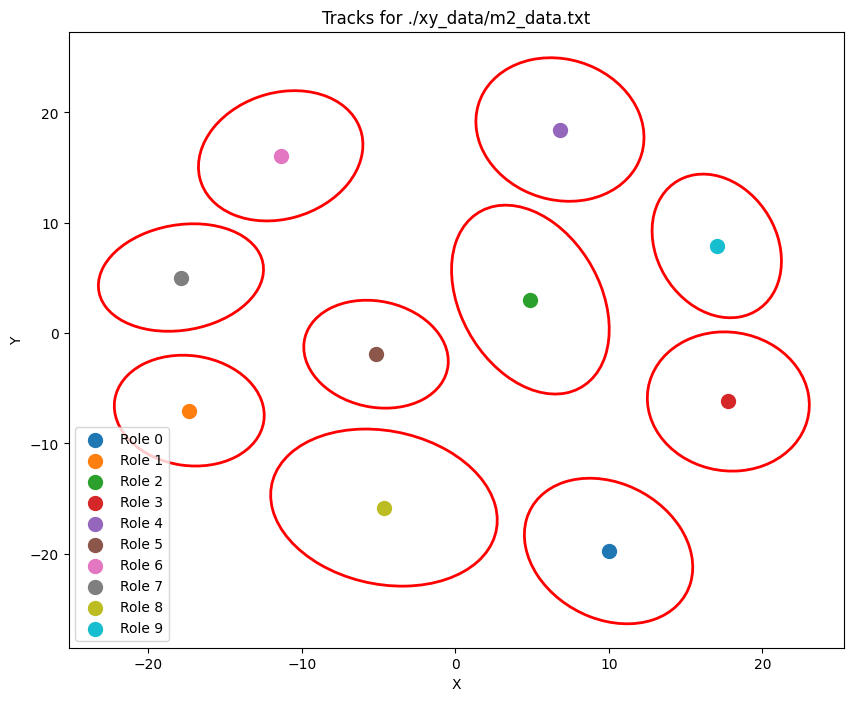

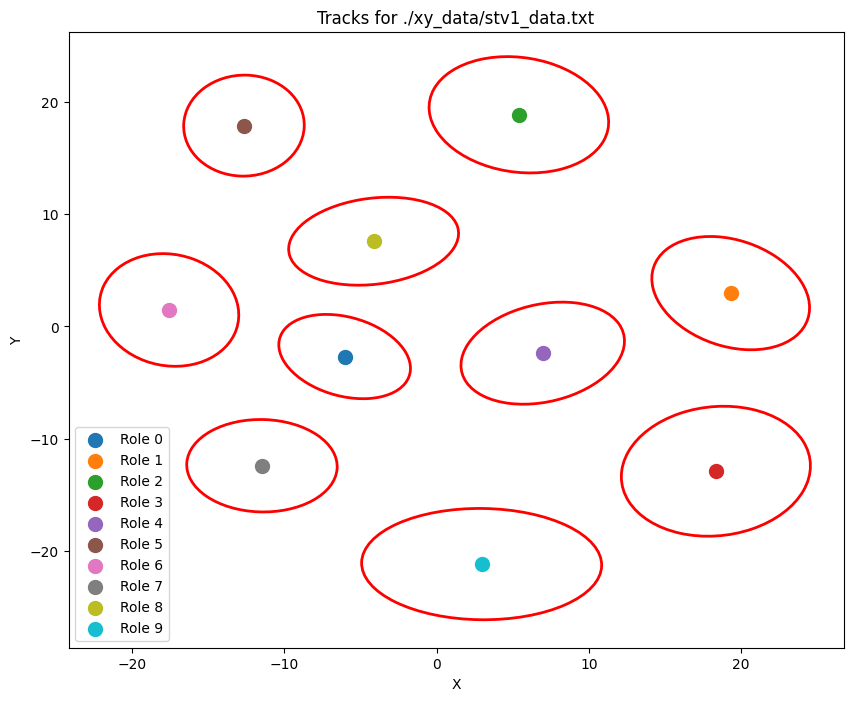

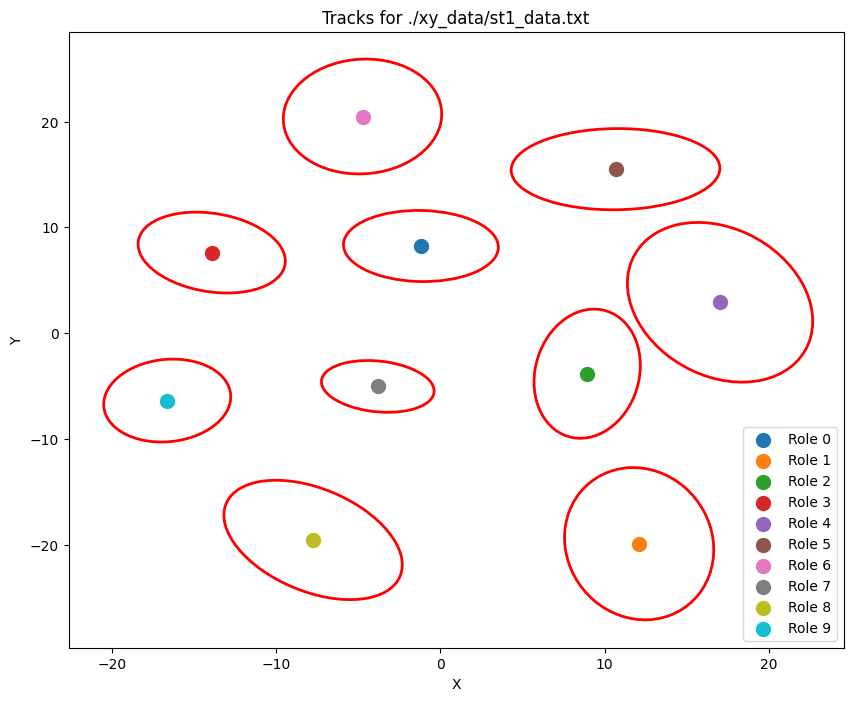

In [30]:
plot_tracks(tracks_role_0)

## Plot formations of role 1

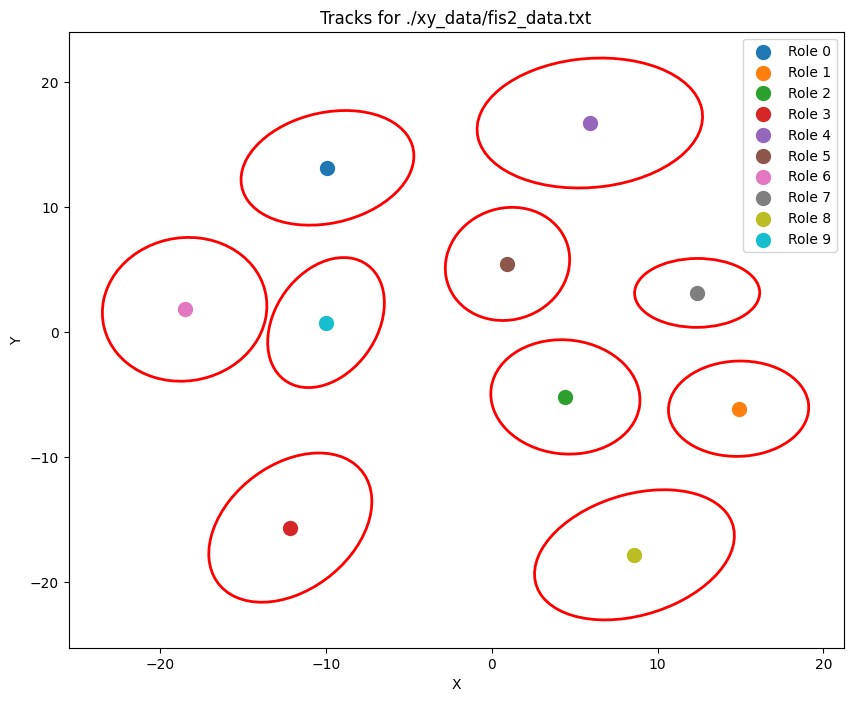

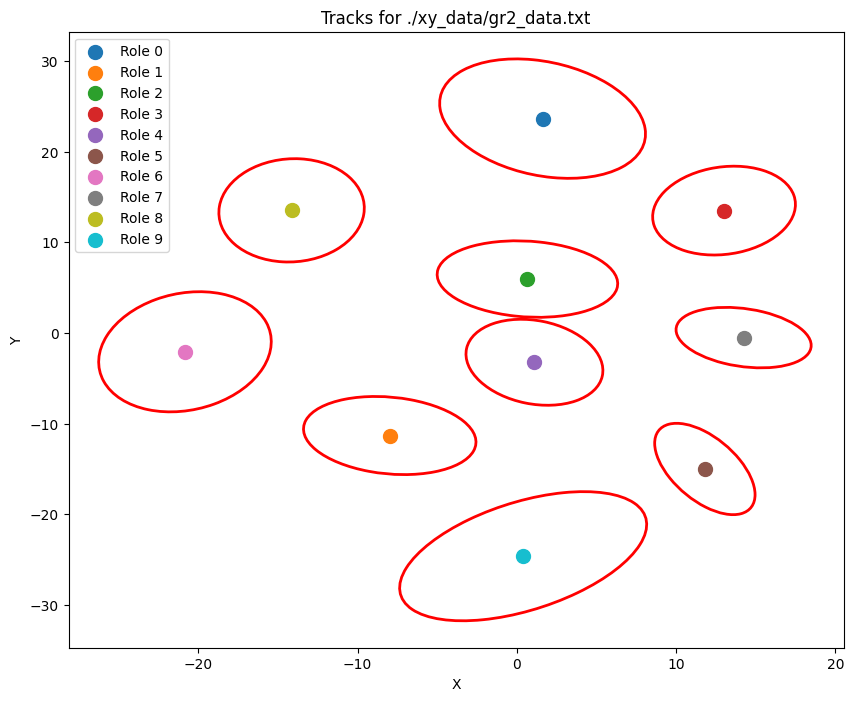

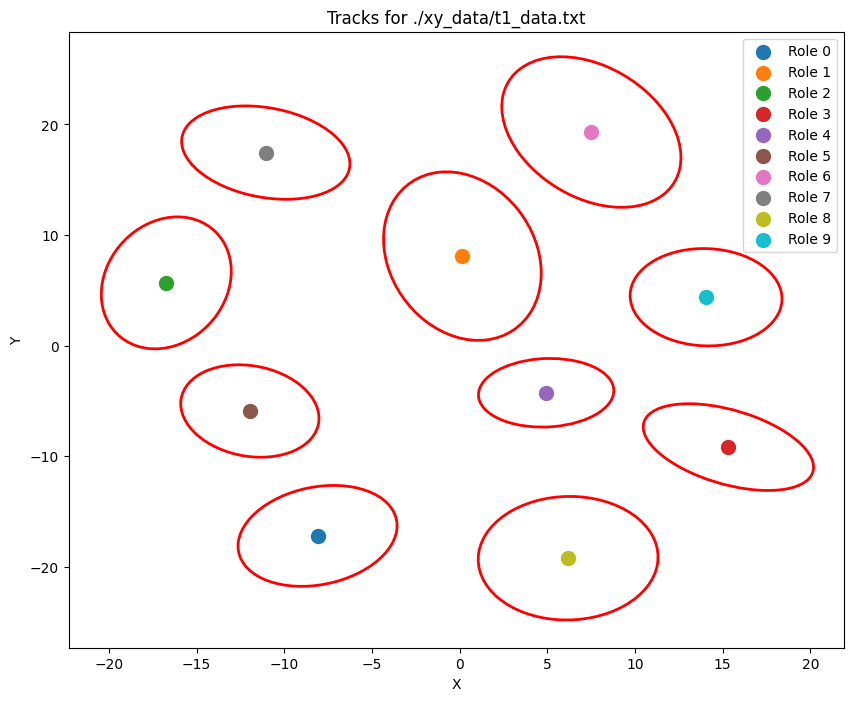

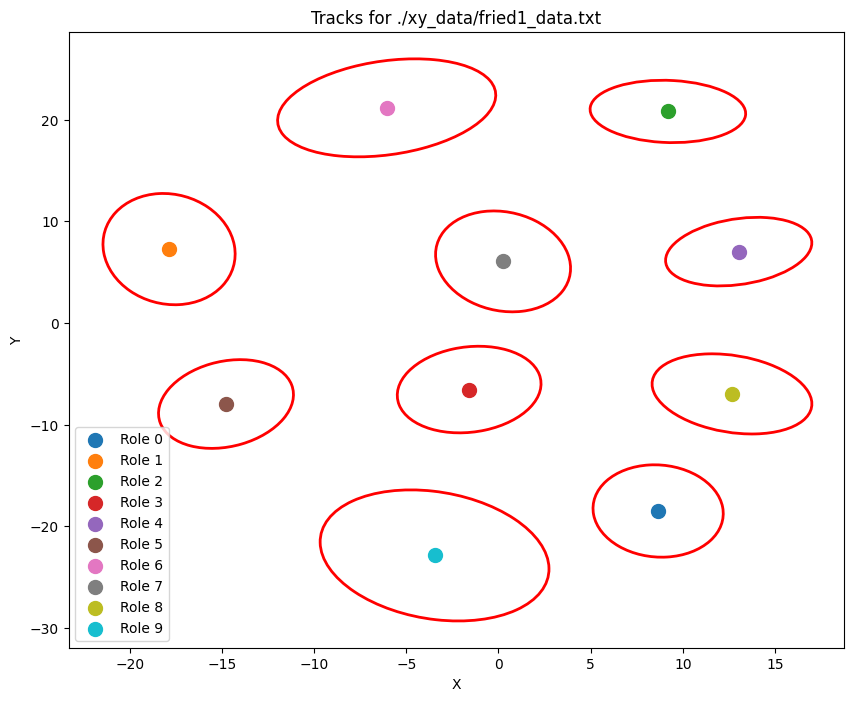

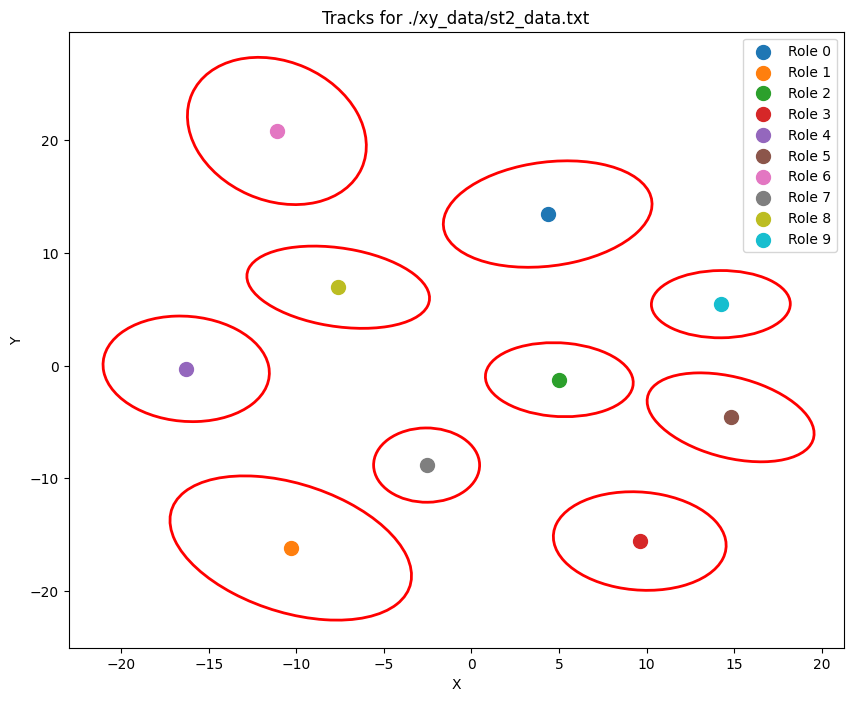

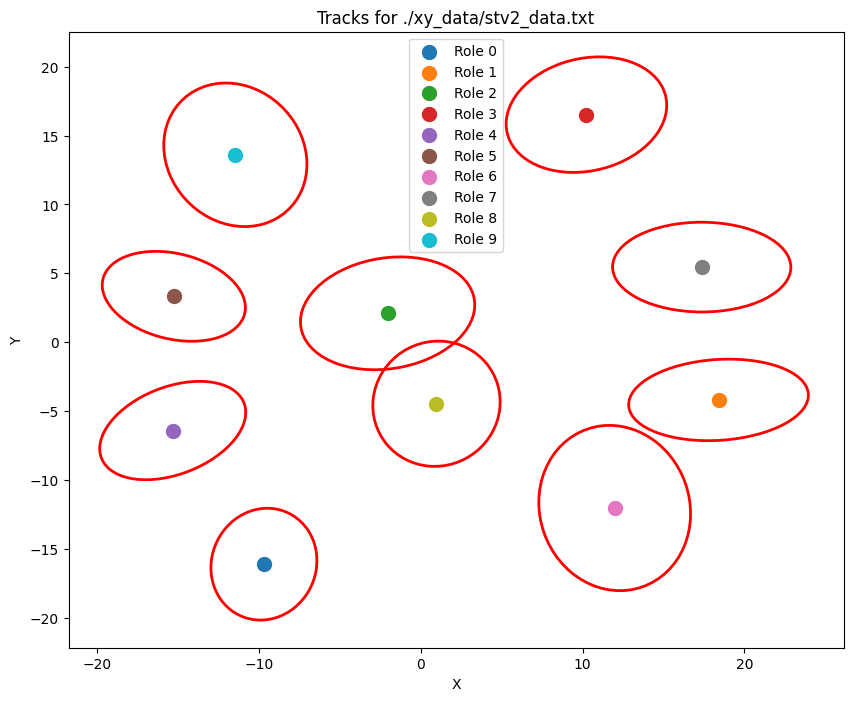

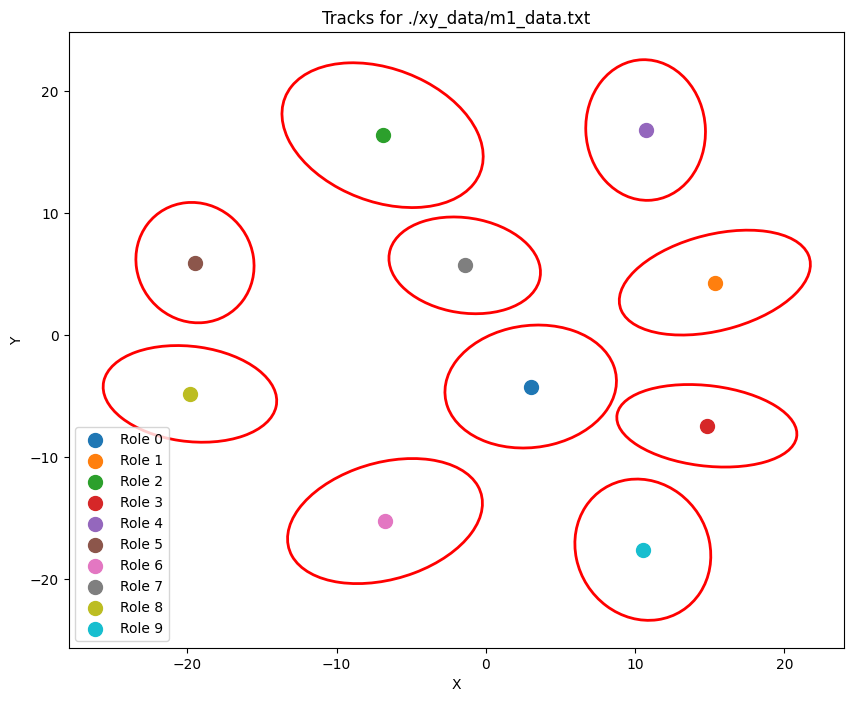

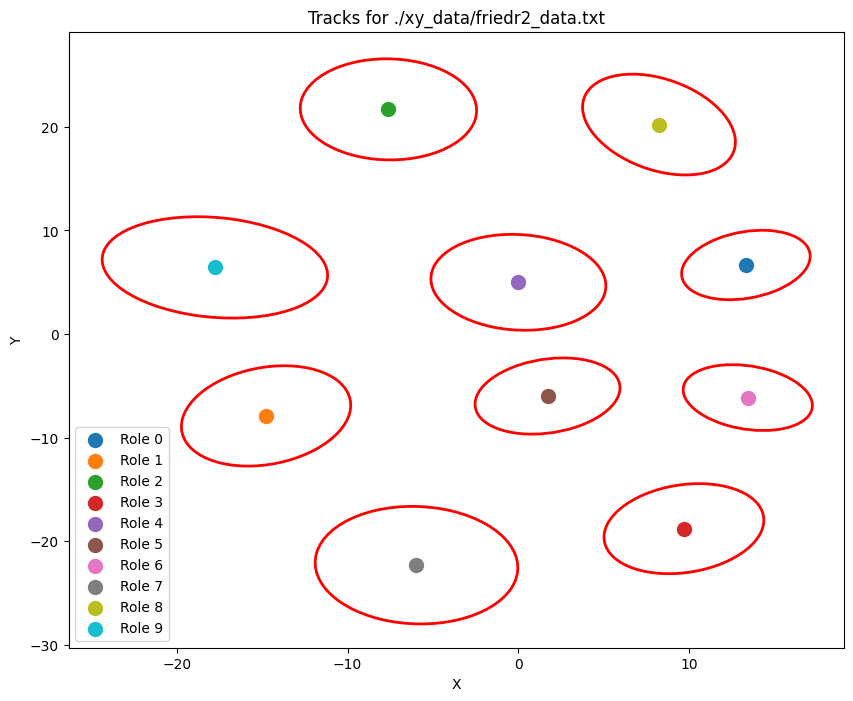

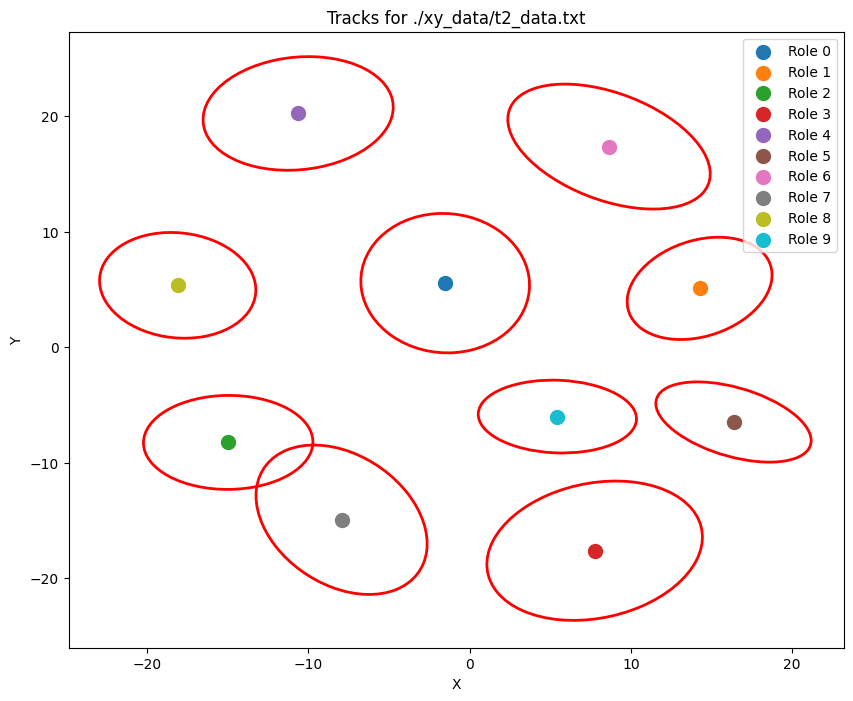

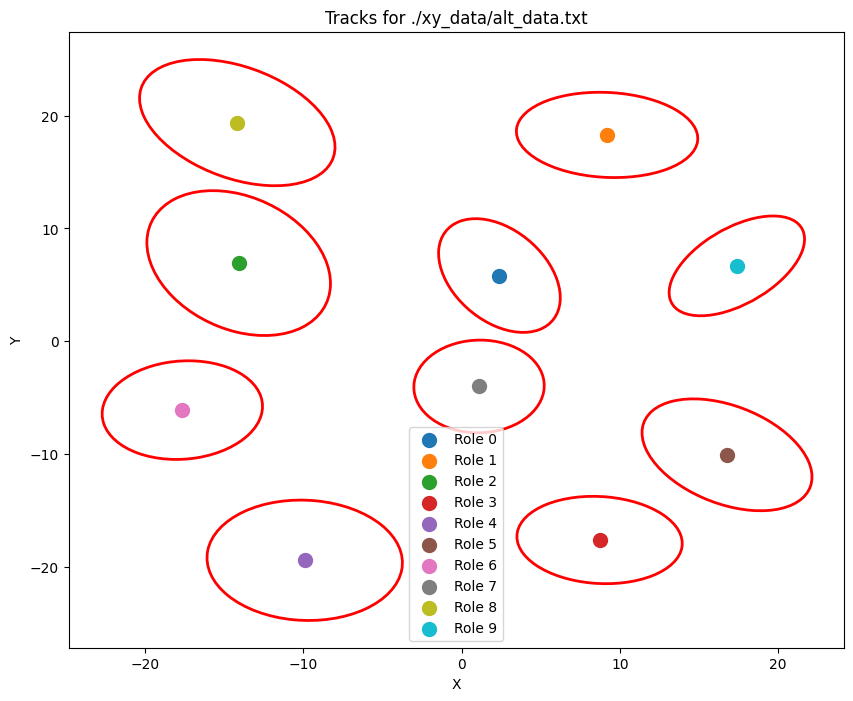

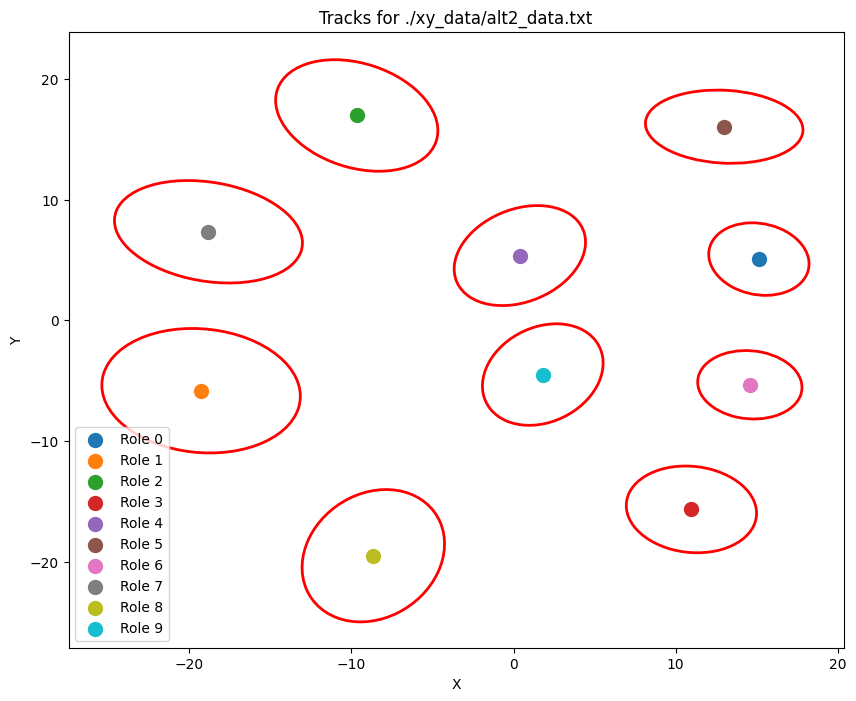

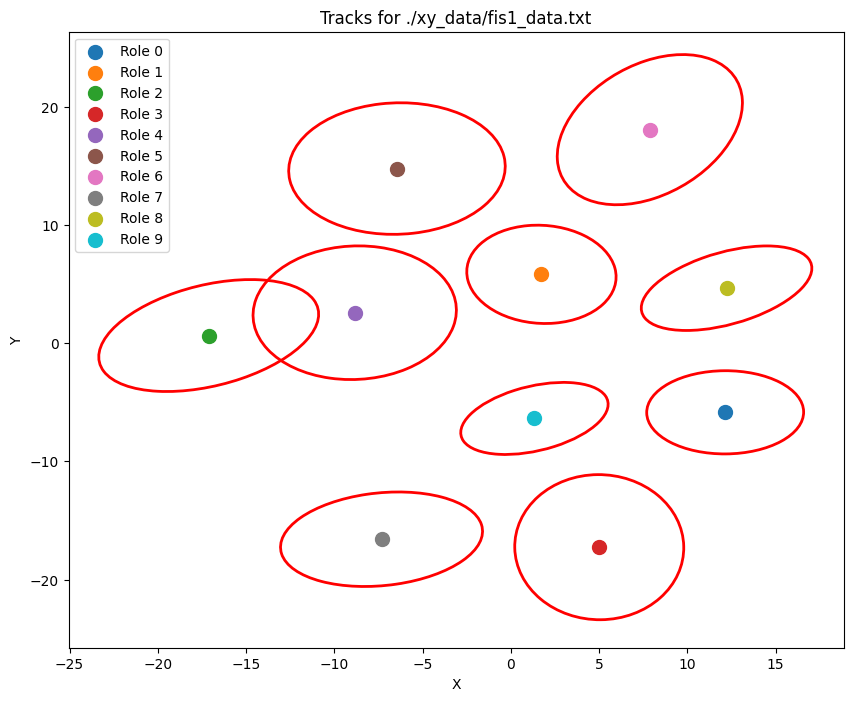

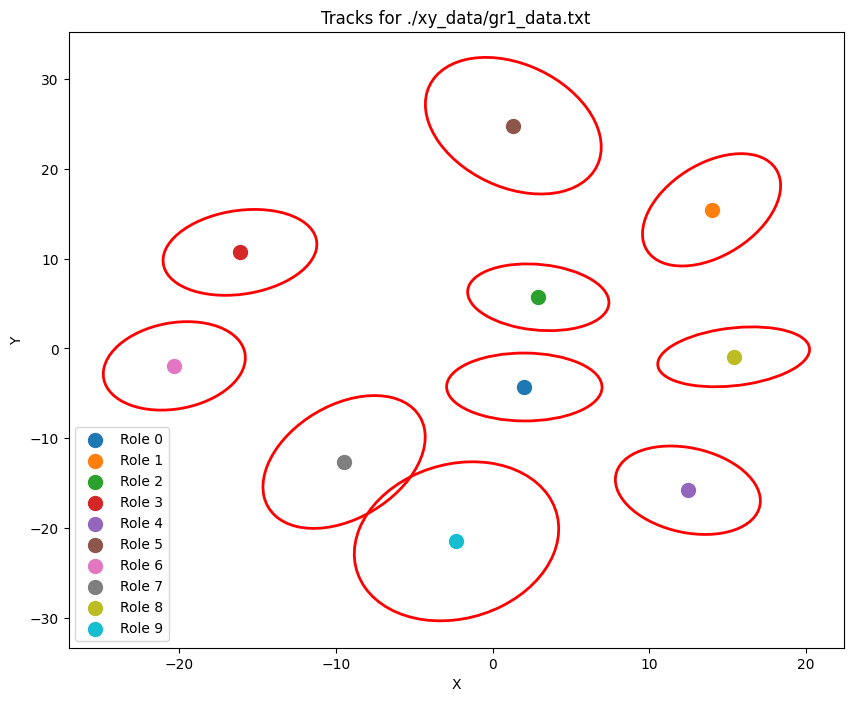

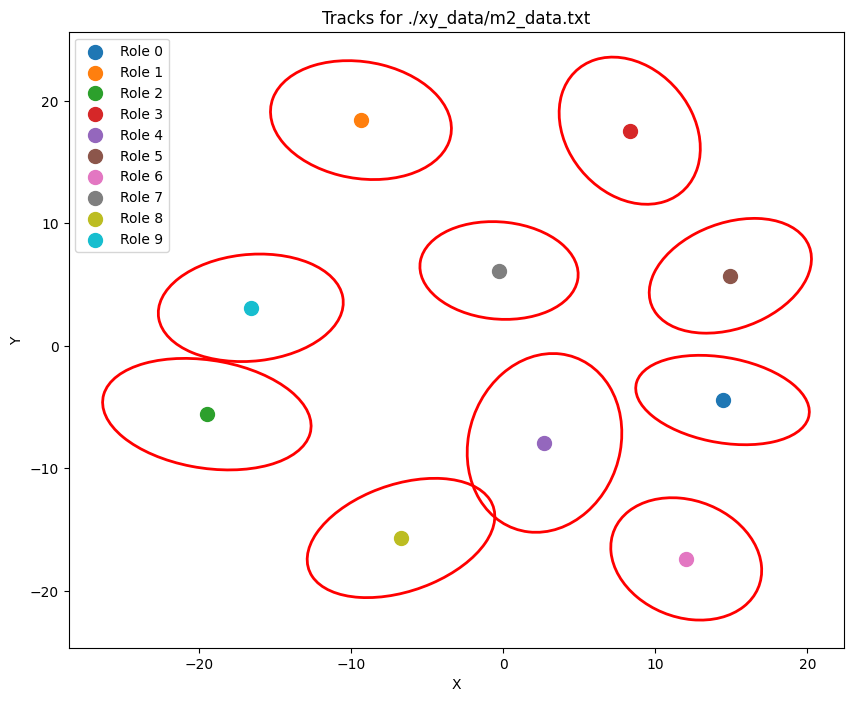

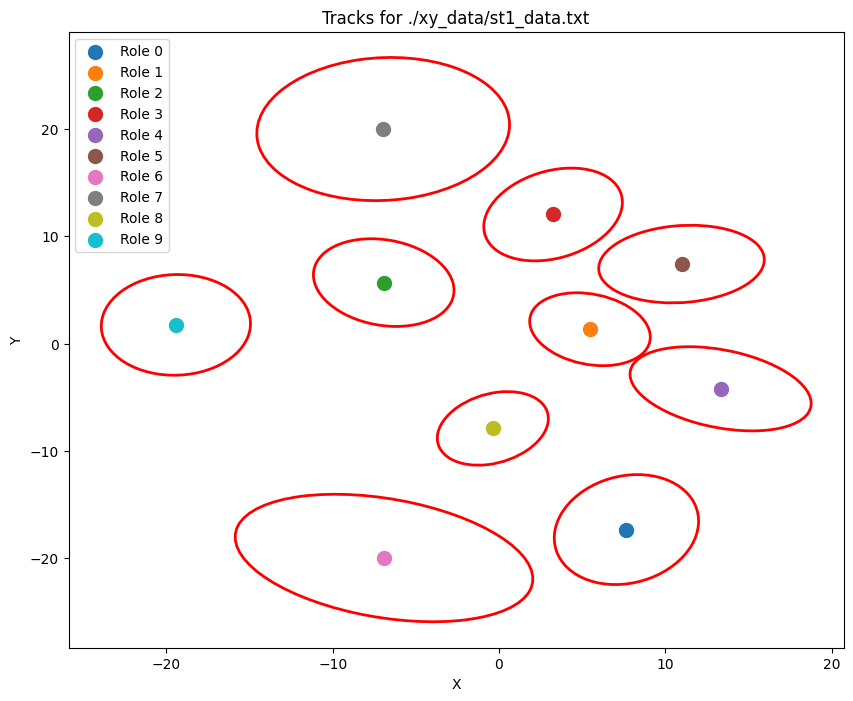

In [31]:
plot_tracks(tracks_role_1)

## Agglomerative Clustering for role 1 and 0

In [28]:
from sklearn.cluster import AgglomerativeClustering

# Set your desired number of clusters (or adjust parameters as needed)
desired_number_of_clusters = 3  # for example

clustering_1 = AgglomerativeClustering(
    n_clusters=desired_number_of_clusters,
    metric='precomputed',  # For older versions of scikit-learn; in newer ones, use metric='precomputed'
    linkage='average'
)

# Get cluster labels for each formation
cluster_labels_1 = clustering_1.fit_predict(distance_matrix_1)

# You can then examine which team (or formation) is in which cluster:
for team, label in zip(team_names_1, cluster_labels_1):
    print(f"Team {team} is in cluster {label}")


Team ./xy_data/fis2_data.txt is in cluster 0
Team ./xy_data/gr2_data.txt is in cluster 1
Team ./xy_data/t1_data.txt is in cluster 0
Team ./xy_data/fried1_data.txt is in cluster 0
Team ./xy_data/st2_data.txt is in cluster 2
Team ./xy_data/stv2_data.txt is in cluster 0
Team ./xy_data/m1_data.txt is in cluster 0
Team ./xy_data/friedr2_data.txt is in cluster 0
Team ./xy_data/t2_data.txt is in cluster 0
Team ./xy_data/alt_data.txt is in cluster 0
Team ./xy_data/alt2_data.txt is in cluster 0
Team ./xy_data/fis1_data.txt is in cluster 0
Team ./xy_data/gr1_data.txt is in cluster 1
Team ./xy_data/m2_data.txt is in cluster 0
Team ./xy_data/st1_data.txt is in cluster 2


In [29]:
from sklearn.cluster import AgglomerativeClustering


clustering_0 = AgglomerativeClustering(
    n_clusters=desired_number_of_clusters,
    metric='precomputed',  # For older versions of scikit-learn; in newer ones, use metric='precomputed'
    linkage='average'
)

# Get cluster labels for each formation
cluster_labels_0 = clustering_0.fit_predict(distance_matrix_0)

# You can then examine which team (or formation) is in which cluster:
for team, label in zip(team_names_0, cluster_labels_0):
    print(f"Team {team} is in cluster {label}")


Team ./xy_data/fis2_data.txt is in cluster 0
Team ./xy_data/gr2_data.txt is in cluster 2
Team ./xy_data/t1_data.txt is in cluster 2
Team ./xy_data/st2_data.txt is in cluster 2
Team ./xy_data/stv2_data.txt is in cluster 2
Team ./xy_data/m1_data.txt is in cluster 2
Team ./xy_data/friedr2_data.txt is in cluster 1
Team ./xy_data/t2_data.txt is in cluster 2
Team ./xy_data/alt_data.txt is in cluster 2
Team ./xy_data/alt2_data.txt is in cluster 2
Team ./xy_data/fis1_data.txt is in cluster 0
Team ./xy_data/gr1_data.txt is in cluster 2
Team ./xy_data/m2_data.txt is in cluster 0
Team ./xy_data/stv1_data.txt is in cluster 0
Team ./xy_data/st1_data.txt is in cluster 2


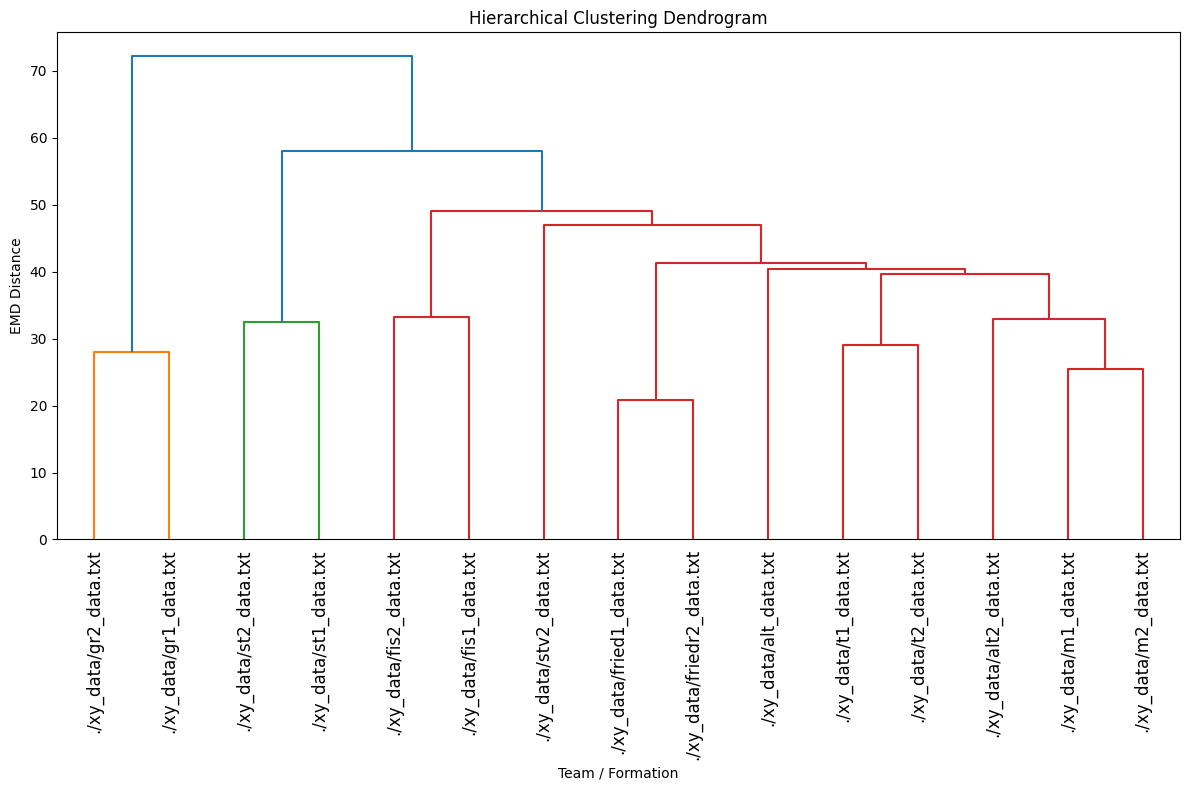

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.cluster import AgglomerativeClustering

# --- Part 1: Plot the Hierarchical Dendrogram ---

# Convert the full (symmetric) distance matrix to condensed form for the linkage function
condensed_distance = squareform(distance_matrix)

# Compute the linkage matrix; here we use 'average' linkage (you can change this if needed)
linkage_matrix = linkage(condensed_distance, method='average')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=team_names, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Team / Formation')
plt.ylabel('EMD Distance')
plt.tight_layout()
plt.show()




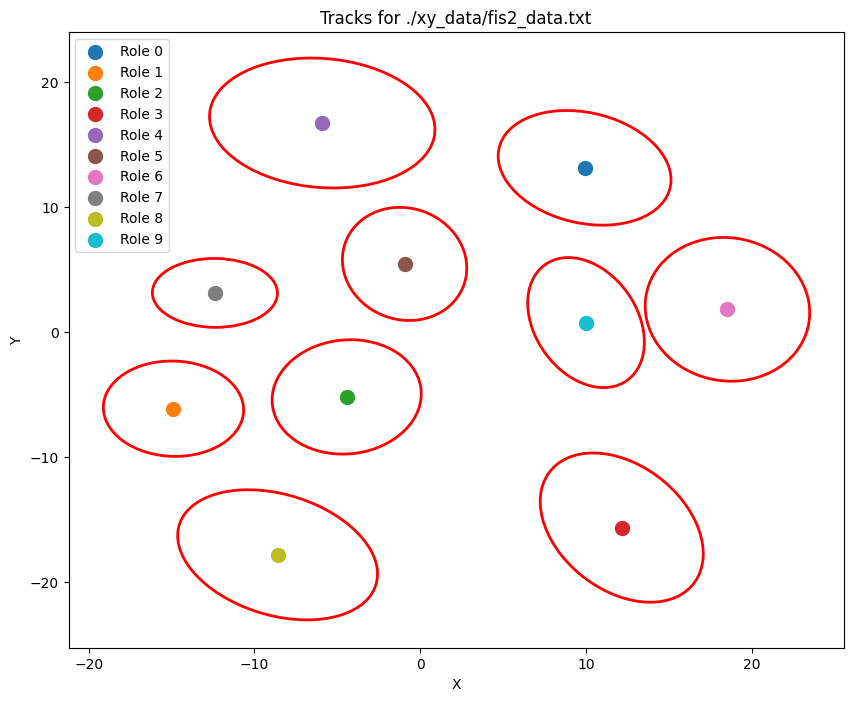

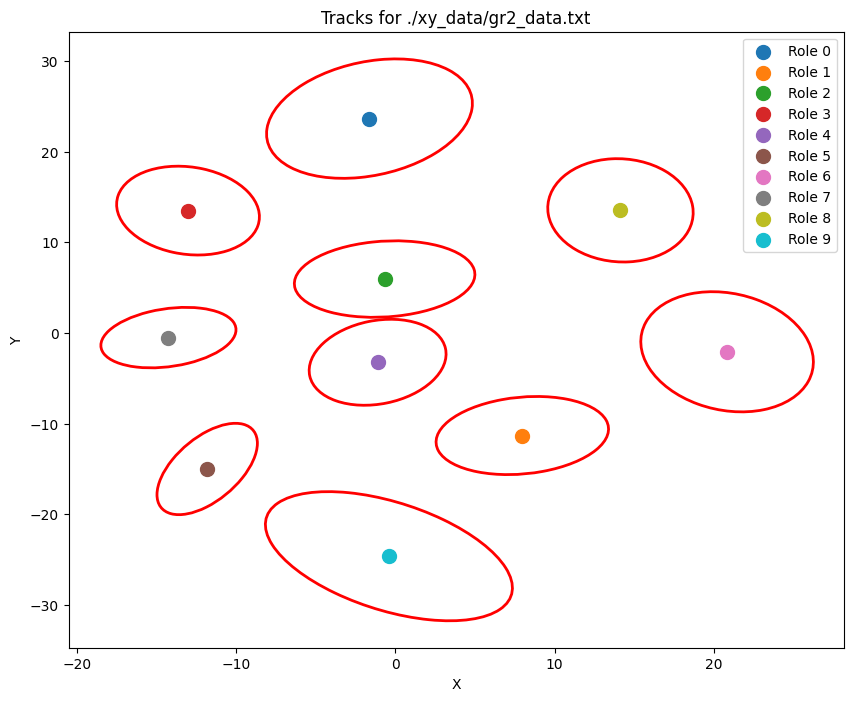

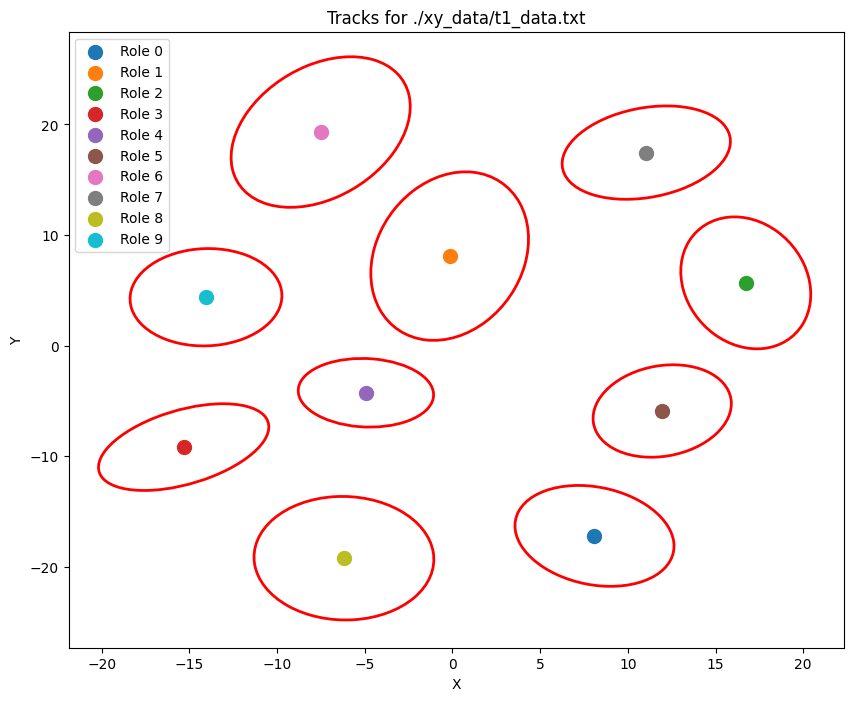

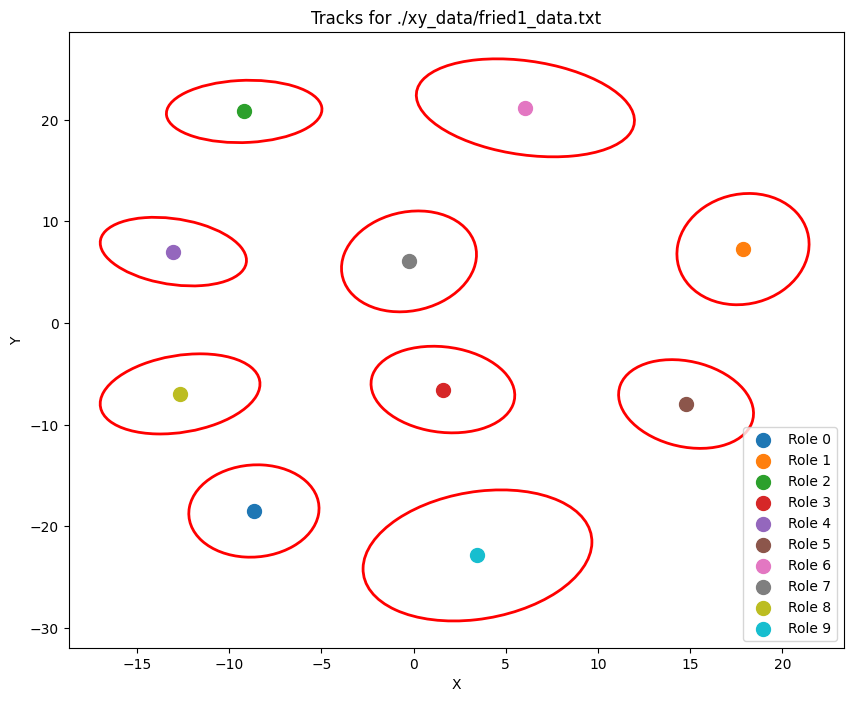

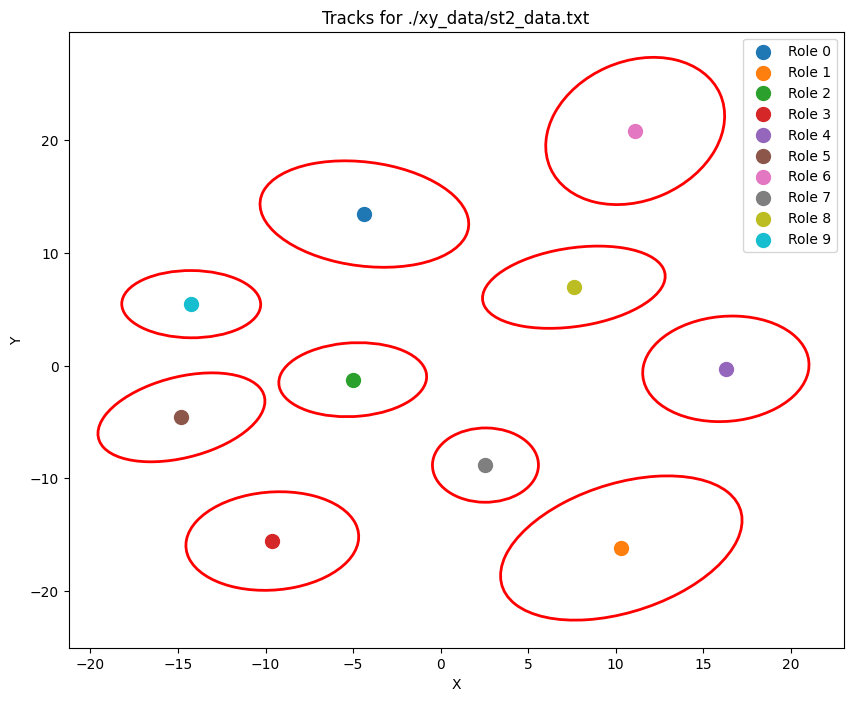

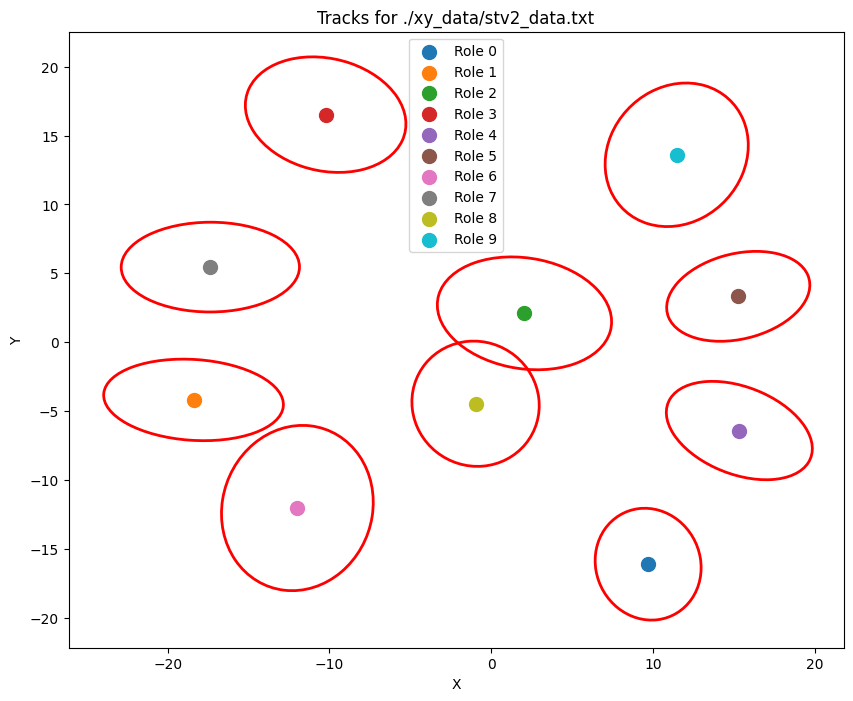

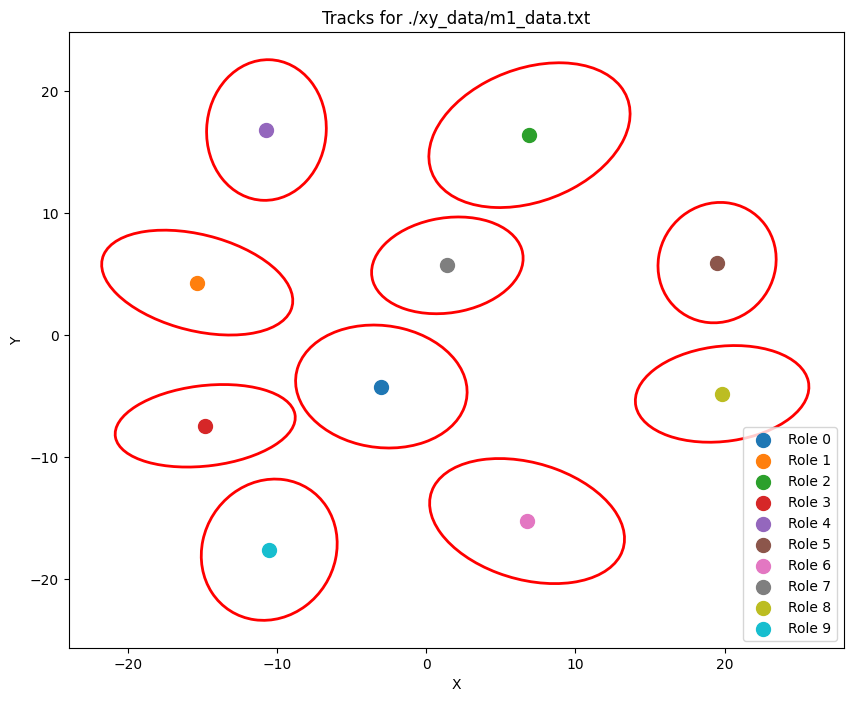

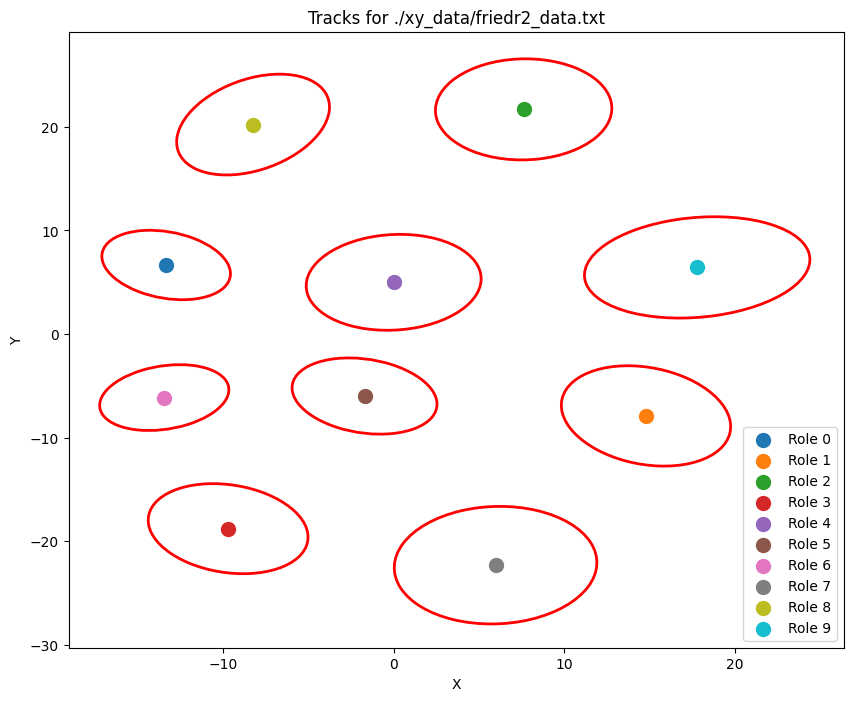

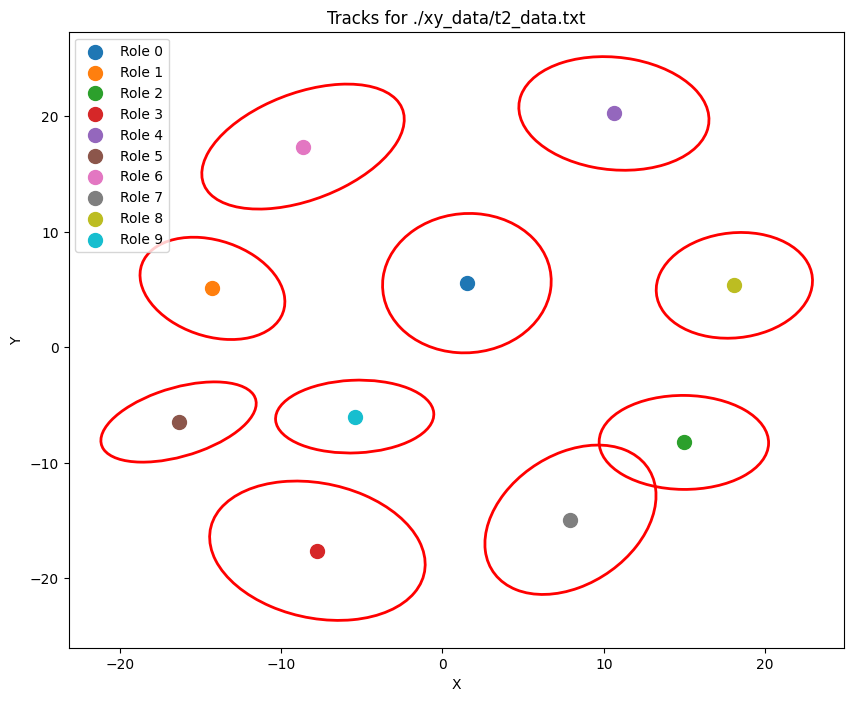

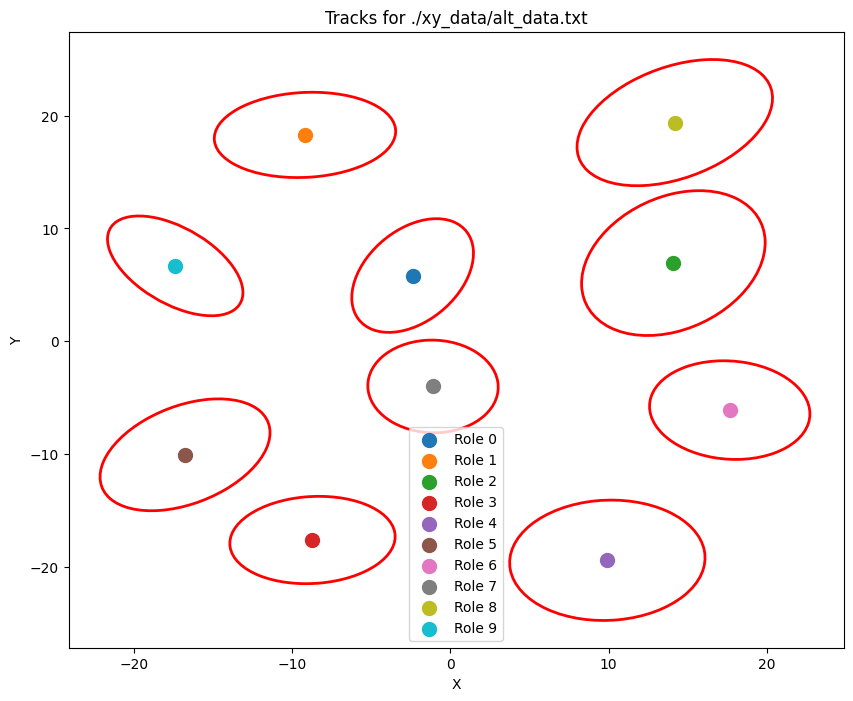

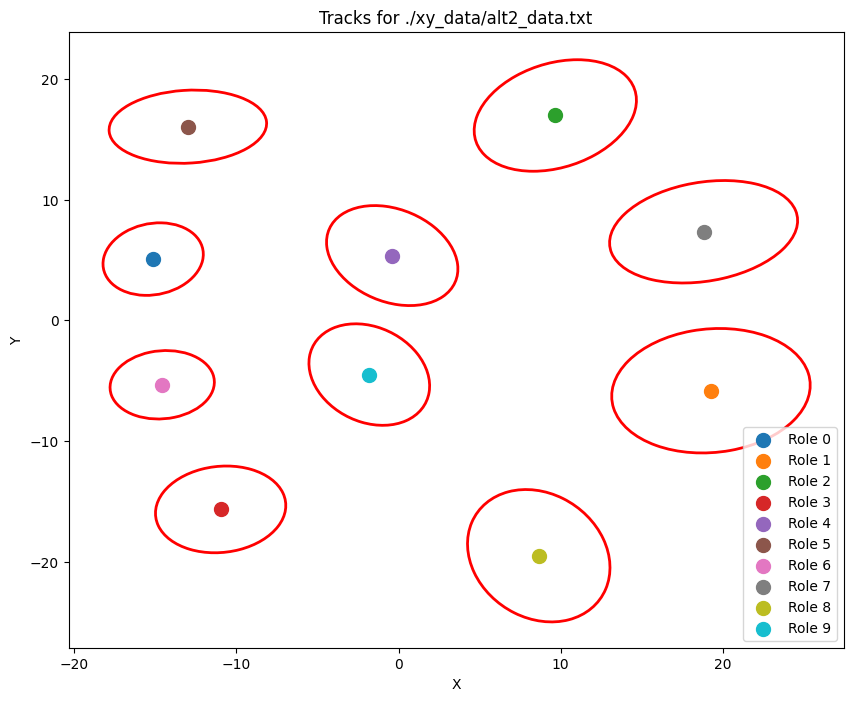

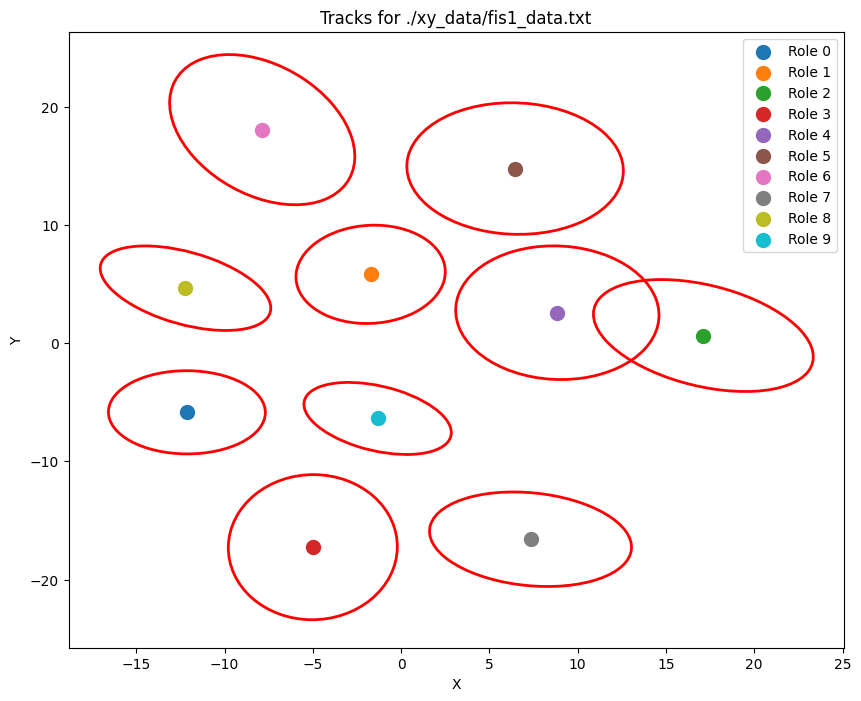

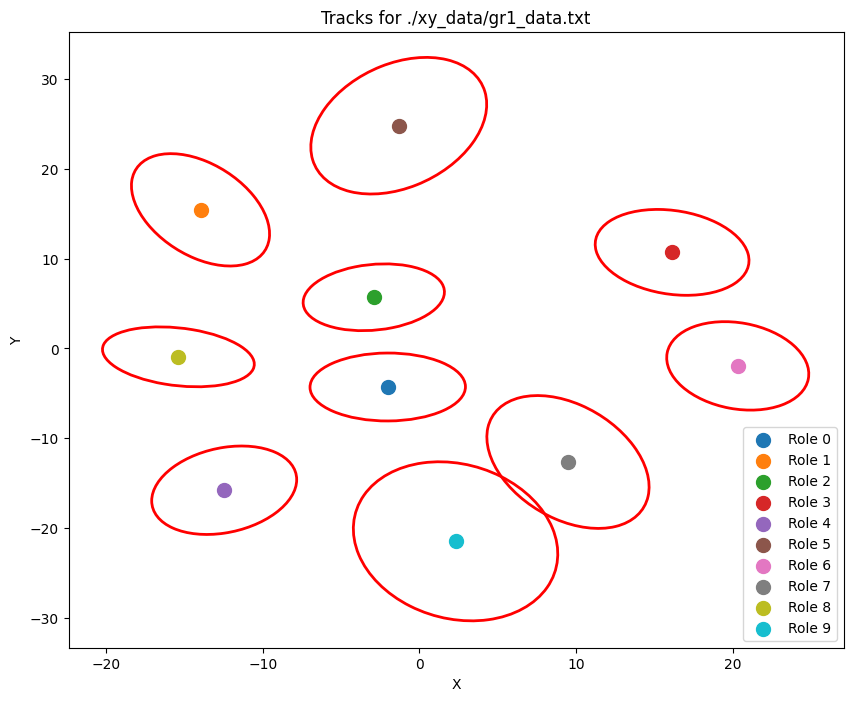

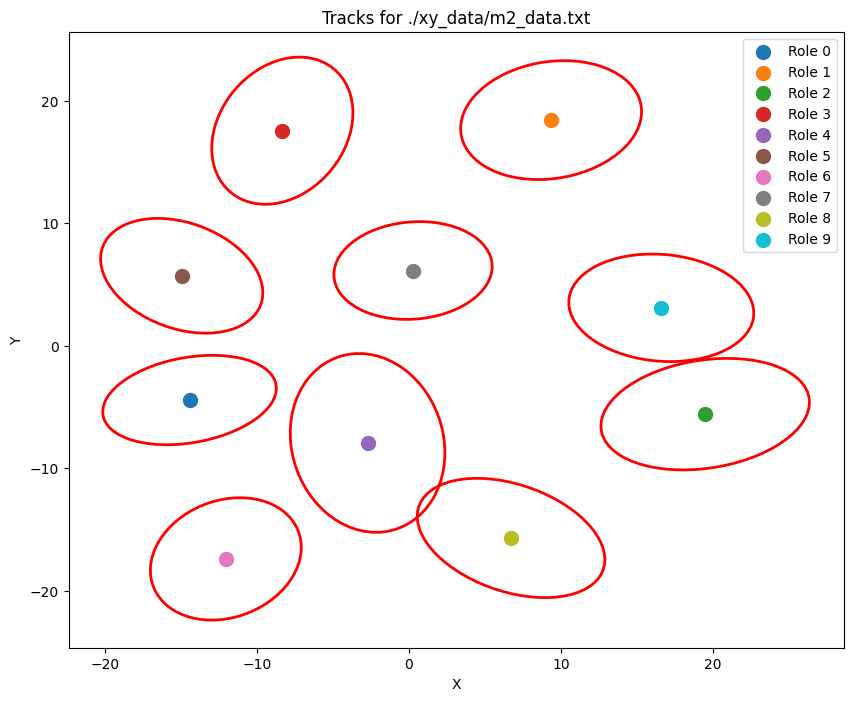

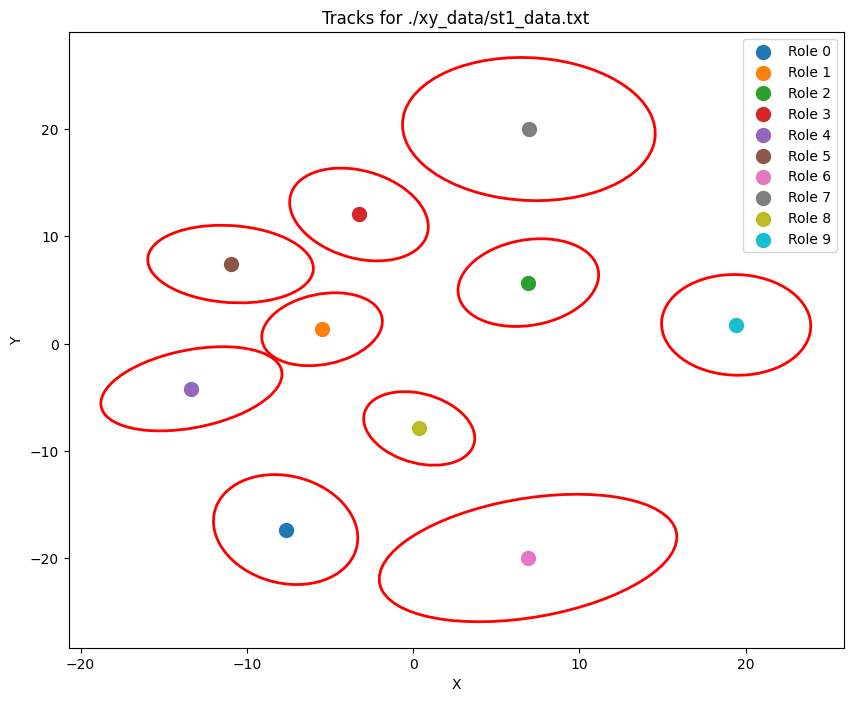

In [35]:
def mirror_tracks_along_x(tracks):
    mirrored_tracks = {}
    for filename, roles in tracks.items():
        mirrored_roles = {}
        for role_id, pdf in roles.items():
            mean = pdf.mean
            cov = pdf.cov
            mirrored_mean = np.array([-mean[0], mean[1]])
            mirrored_cov = cov.copy()
            mirrored_cov[0, 0] = cov[0, 0]  # Keep the original variance
            mirrored_cov[0, 1] = -cov[0, 1]  # Mirror the covariance
            mirrored_cov[1, 0] = -cov[1, 0]  # Mirror the covariance
            mirrored_roles[role_id] = multivariate_normal(mean=mirrored_mean, cov=mirrored_cov)
        mirrored_tracks[filename] = mirrored_roles
    return mirrored_tracks

mirrored_tracks_role_1 = mirror_tracks_along_x(tracks_role_1)

plot_tracks(mirrored_tracks_role_1)

In [36]:
import json
from scipy.stats import multivariate_normal

def serialize_multivariate_normal(mvn):
    return {
        'mean': mvn.mean.tolist(),
        'covariance': mvn.cov.tolist()
    }

tracks_role_1_serializable_mirrored = {
    filename: {str(role_id): serialize_multivariate_normal(pdf) for role_id, pdf in roles.items()}
    for filename, roles in mirrored_tracks_role_1.items()
}



with open('tracks_role_1_mirrored.json', 'w') as f:
    json.dump(tracks_role_1_serializable_mirrored, f)

In [37]:
import json

# Load the JSON data from the two files
with open('tracks_role_0.json', 'r') as f:
    tracks_role_0 = json.load(f)

with open('tracks_role_1_mirrored.json', 'r') as f:
    tracks_role_1_mirrored = json.load(f)

# Combine the data into a single dictionary
combined_tracks = {}
for team in tracks_role_0.keys():
    combined_tracks[team] = {
        "roles_0": tracks_role_0[team],
        "roles_1": tracks_role_1_mirrored.get(team, {})
    }

# Save the combined data to a new JSON file
with open('tracks.json', 'w') as f:
    json.dump(combined_tracks, f, indent=4)

In [38]:
import json
import numpy as np

# Load your JSON data
with open('tracks.json', 'r') as f:
    data = json.load(f)

formations = []  # List to store each team's formation as a list of players.
team_names = []  # To keep track of team IDs

for team, roles in data.items():
    for role_key, players in roles.items():
        formation = []
        for player, stats in players.items():
            mean = np.array(stats['mean'])           # e.g., [x, y]
            covariance = np.array(stats['covariance']) # e.g., 2x2 matrix
            formation.append((mean, covariance))
        formations.append(formation)
        team_names.append(f"{team}_{role_key}")

num_formations = len(formations)
print(f"Number of formations: {num_formations}")
distance_matrix = np.zeros((num_formations, num_formations))

for i in range(num_formations):
    for j in range(i + 1, num_formations):
        distance = compute_emd(formations[i], formations[j])
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance  # because the distance is symmetric


Number of formations: 30


In [41]:
from sklearn.cluster import AgglomerativeClustering


clustering = AgglomerativeClustering(
    n_clusters=3,
    metric='precomputed',  # For older versions of scikit-learn; in newer ones, use metric='precomputed'
    linkage='average'
)

# Get cluster labels for each formation
cluster_labels = clustering.fit_predict(distance_matrix)

# You can then examine which team (or formation) is in which cluster:
for team, label in zip(team_names, cluster_labels):
    print(f"Team {team} is in cluster {label}")


Team ./xy_data/fis2_data.txt_roles_0 is in cluster 0
Team ./xy_data/fis2_data.txt_roles_1 is in cluster 0
Team ./xy_data/gr2_data.txt_roles_0 is in cluster 0
Team ./xy_data/gr2_data.txt_roles_1 is in cluster 1
Team ./xy_data/t1_data.txt_roles_0 is in cluster 0
Team ./xy_data/t1_data.txt_roles_1 is in cluster 0
Team ./xy_data/st2_data.txt_roles_0 is in cluster 0
Team ./xy_data/st2_data.txt_roles_1 is in cluster 0
Team ./xy_data/stv2_data.txt_roles_0 is in cluster 0
Team ./xy_data/stv2_data.txt_roles_1 is in cluster 0
Team ./xy_data/m1_data.txt_roles_0 is in cluster 0
Team ./xy_data/m1_data.txt_roles_1 is in cluster 0
Team ./xy_data/friedr2_data.txt_roles_0 is in cluster 2
Team ./xy_data/friedr2_data.txt_roles_1 is in cluster 0
Team ./xy_data/t2_data.txt_roles_0 is in cluster 0
Team ./xy_data/t2_data.txt_roles_1 is in cluster 0
Team ./xy_data/alt_data.txt_roles_0 is in cluster 0
Team ./xy_data/alt_data.txt_roles_1 is in cluster 0
Team ./xy_data/alt2_data.txt_roles_0 is in cluster 0
Team 